<a href="https://colab.research.google.com/github/noralizaaa/Klasifikasi-Burnout-pada-Mahasiswa-dan-Pekerja/blob/main/Project_Machine_Learning_(Klasifikasi_Burnout).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nama Anggota:**


**- Nur Fitrah Wahyuni (202210370311213)**


**- Noraliza Putri Nabila (202210370311216)**

# **Project – Klasifikasi Burnout Pada Mahasiswa dan Pekerja**

Notebook ini berisi proses pembangunan model untuk mengklasifikasikan tingkat burnout pada mahasiswa, pekerja, dan tidak burnout menggunakan pendekatan Machine Learning, Deep Learning, serta model Pre-trained seperti DistilBERT.

Notebook ini menyajikan seluruh tahapan analisis secara komprehensif:
1. Business Objective
2. Preprocessing & Transformation
3. Feature Engineering
4. Evaluasi Metode Klasik, Deep Learning,Transfer learning dan LoRA.
5. Error Analysis
6. Explainable AI (LIME)
7. Perbandingan kinerja model

Melalui proyek ini, diharapakan diperoleh model yang akurat, robust, dan explainable untuk mendukung strategi intervensi kampus dan perusahaan dalam mengatasi burnout.

**Import Library**

In [1]:
# ==========================================
# Impor Library yang Dibutuhkan
# ==========================================
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import pandas as pd
import torch
import os
from google.colab import drive
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from IPython.display import display
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.exceptions import ConvergenceWarning
import warnings

# Download stopwords (dibutuhkan untuk fungsi clean_text)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Abaikan warning konvergensi agar output lebih bersih
warnings.filterwarnings("ignore", category=ConvergenceWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# ==========================================
# 11. Impor Library Model Klasifikasi
# ==========================================
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns


# Abaikan warning konvergensi agar output lebih bersih
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning) # Untuk XGBoost

**Load Dataset**

In [ ]:
# ==========================================
# 2. Load Dataset & Model SBERT
# ==========================================
print("📥 Memuat dataset mentah dari Hugging Face...")
dataset = load_dataset("Villian7/Emotions_Data", split="all")
df = pd.DataFrame(dataset)
df = df.dropna(subset=['text']).reset_index(drop=True)
print(f"Total data awal: {len(df):,}")

print("🧠 Memuat model Sentence Transformer...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device=device)

# ==========================================
# 3. Definisi Kategori & Queries (3 Kategori)
# ==========================================
categories = {
    "college_burnout": [
        "burnout among college students",
        "academic exhaustion among university students",
        "mental fatigue due to studying in college",
        "college students feel emotionally exhausted",
        "burnout from university assignments and exams",
        "stressed about finals and thesis",
        "overwhelmed by coursework"
    ],
    "worker_burnout": [
        "burnout among employees",
        "job-related exhaustion",
        "workplace stress and fatigue",
        "mental fatigue due to work pressure",
        "emotional exhaustion from office work",
        "overworked and underappreciated at my job",
        "feeling cynical about my career"
    ],
    "no_burnout": [
        # Kueri ini untuk menangkap emosi umum / non-spesifik
        "I feel happy today",
        "I am feeling sad",
        "This makes me angry",
        "I am scared of this",
        "Feeling joyful and content",
        "General daily life thoughts",
        "Neutral statement about the day",
        "I'm feeling excited",
        "I feel calm and relaxed"
    ]
}

# ==========================================
# 4. Encoding Teks (Seluruh Dataset)
# ==========================================
print("🔢 Mengubah semua teks menjadi embedding (ini mungkin butuh waktu)...")
text_embeddings = model.encode(
    df["text"].tolist(),
    convert_to_tensor=True,
    batch_size=256,
    show_progress_bar=True
)

# ==========================================
# 5. Hitung Similarity & Tentukan Label Terbaik
# ==========================================
results = []
for label, queries in categories.items():
    print(f"⚙ Menghitung kesamaan untuk kategori: {label} ...")
    query_embeddings = model.encode(queries, convert_to_tensor=True)

    # Hitung cos_sim
    similarity_scores = util.cos_sim(text_embeddings, query_embeddings)

    # Ambil skor tertinggi untuk setiap teks terhadap kueri kategori ini
    max_scores, _ = torch.max(similarity_scores, dim=1)

    # Buat dataframe sementara
    df_temp = df.copy()
    df_temp["similarity_score"] = max_scores.cpu().numpy()
    df_temp["label"] = label
    results.append(df_temp)

# Gabungkan semua hasil
combined_df = pd.concat(results, ignore_index=True)

# Pilih label dengan SKOR TERTINGGI untuk setiap teks
print("\n🔍 Memilih label dengan similarity score tertinggi per teks...")
final_labeled_df = combined_df.loc[combined_df.groupby("text")["similarity_score"].idxmax()].reset_index(drop=True)

# ==========================================
# 6. Terapkan Threshold & Aturan Max 2000
# ==========================================
threshold = 0.40  # Kita gunakan threshold yang sedikit lebih rendah
df_after_thresh = final_labeled_df[final_labeled_df["similarity_score"] >= threshold].reset_index(drop=True)
print(f"Data setelah threshold ({threshold}): {len(df_after_thresh):,} rows")

# --- Menerapkan aturan 'no_burnout' max 2000 ---
print("\nMenerapkan aturan max 2000 untuk 'no_burnout'...")
df_burnout_categories = df_after_thresh[df_after_thresh['label'] != 'no_burnout']
df_no_burnout_category = df_after_thresh[df_after_thresh['label'] == 'no_burnout']

print(f"Data 'no_burnout' yang ditemukan (sebelum sampling): {len(df_no_burnout_category)}")
max_no_burnout = 2000
if len(df_no_burnout_category) > max_no_burnout:
    df_no_burnout_category = df_no_burnout_category.sample(n=max_no_burnout, random_state=42)
    print(f"Data 'no_burnout' disampling menjadi: {len(df_no_burnout_category)}")

# --- Gabungkan kembali ---
df_final = pd.concat([df_burnout_categories, df_no_burnout_category], ignore_index=True)
# Acak urutan data
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ Dataset final (3 kelas) siap: {len(df_final):,} rows")
print("Distribusi Kelas Final:")
print(df_final['label'].value_counts())

# Simpan hasil gabungan
output_path = "/content/Burnout_3_Class_Filtered.csv"
df_final.to_csv(output_path, index=False)
print("✅ Dataset final disimpan langsung di Colab:", output_path)

📥 Memuat dataset mentah dari Hugging Face...


README.md:   0%|          | 0.00/758 [00:00<?, ?B/s]

data/train-00000-of-00001-bd90147cb7ed11(…):   0%|          | 0.00/62.6M [00:00<?, ?B/s]

data/validation-00000-of-00001-51e4f3beb(…):   0%|          | 0.00/7.45M [00:00<?, ?B/s]

data/test-00000-of-00001-a6072f77b7d062e(…):   0%|          | 0.00/7.46M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1096869 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133105 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/133104 [00:00<?, ? examples/s]

Total data awal: 1,363,078
🧠 Memuat model Sentence Transformer...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🔢 Mengubah semua teks menjadi embedding (ini mungkin butuh waktu)...


Batches:   0%|          | 0/5325 [00:00<?, ?it/s]

⚙ Menghitung kesamaan untuk kategori: college_burnout ...
⚙ Menghitung kesamaan untuk kategori: worker_burnout ...
⚙ Menghitung kesamaan untuk kategori: no_burnout ...

🔍 Memilih label dengan similarity score tertinggi per teks...
Data setelah threshold (0.4): 223,249 rows

Menerapkan aturan max 2000 untuk 'no_burnout'...
Data 'no_burnout' yang ditemukan (sebelum sampling): 200045
Data 'no_burnout' disampling menjadi: 2000

✅ Dataset final (3 kelas) siap: 25,204 rows
Distribusi Kelas Final:
label
worker_burnout     16648
college_burnout     6556
no_burnout          2000
Name: count, dtype: int64
✅ Dataset final disimpan langsung di Colab: /content/Burnout_3_Class_Filtered.csv


In [3]:
# ==========================================
# 2. Load Dataset
# ==========================================
file_path = "/content/Burnout_3_Class_Filtered (1).csv"
df = pd.read_csv(file_path)

print(df.info())
print("\nDistribusi label:\n", df['label'].value_counts())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              25204 non-null  object 
 1   label             25204 non-null  object 
 2   label_text        25204 non-null  object 
 3   similarity_score  25204 non-null  float64
dtypes: float64(1), object(3)
memory usage: 787.8+ KB
None

Distribusi label:
 label
worker_burnout     16648
college_burnout     6556
no_burnout          2000
Name: count, dtype: int64


text            label  \
0  i just dont understand why i feel so lost abou...  college_burnout   
1                        i feel soo ungrateful today       no_burnout   
2  i do what i do and how i seem to always be pow...   worker_burnout   
3                            i need to feel valuable   worker_burnout   
4  i feel super weak and i havent made it through...  college_burnout   

       label_text  similarity_score  
0  disappointment          0.404118  
1  disappointment          0.492512  
2  disappointment          0.459672  
3             joy          0.497510  
4             joy          0.405756

In [4]:
df.tail()

text            label  \
25199  still feeling emotional fragile keeping busy r...   worker_burnout   
25200                            feel soooooo productive   worker_burnout   
25201             Quiz in every class tomorrow #cantwait  college_burnout   
25202  i quit my job in financial services feeling di...   worker_burnout   
25203                                         sad song n       no_burnout   

           label_text  similarity_score  
25199         sadness          0.412409  
25200             joy          0.457388  
25201             joy          0.430899  
25202         sadness          0.524909  
25203  disappointment          0.407744

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              25204 non-null  object 
 1   label             25204 non-null  object 
 2   label_text        25204 non-null  object 
 3   similarity_score  25204 non-null  float64
dtypes: float64(1), object(3)
memory usage: 787.8+ KB


In [6]:
df.describe()

similarity_score
count      25204.000000
mean           0.469768
std            0.059175
min            0.400000
25%            0.424853
50%            0.454892
75%            0.498762
max            0.851624

In [7]:
df.isnull().sum()

text                0
label               0
label_text          0
similarity_score    0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

**Pre-Processing**

In [10]:
# ==========================================
# 7. Preprocessing Text (Fungsi Anda)
# ==========================================
# (Ini adalah fungsi yang Anda berikan di prompt pertama)
def clean_text_steps_verbose_all(df_text):
    text_series = df_text.copy()

    # Tahap 1: Lowercase
    print("\n=== 1. Lowercase ===")
    pre = text_series
    post = text_series.str.lower()
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 2: Hapus URL
    print("\n=== 2. Hapus URL ===")
    pre = text_series
    post = text_series.str.replace(r"http\S+|www\S+|https\S+", "", regex=True)
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 3: Hapus Emoji / Emoticon
    print("\n=== 3. Hapus Emoji / Emoticon ===")
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               "]+", flags=re.UNICODE)
    pre = text_series
    post = text_series.apply(lambda x: emoji_pattern.sub(r'', x))
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 4: Hapus angka & karakter spesial
    print("\n=== 4. Hapus Angka & Karakter Spesial ===")
    pre = text_series
    post = text_series.str.replace(r"[^a-z\s]", "", regex=True)
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 5: Hapus spasi berlebih
    print("\n=== 5. Hapus Spasi Berlebih ===")
    pre = text_series
    post = text_series.str.replace(r"\s+", " ", regex=True).str.strip()
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 6: Hapus Stopwords
    print("\n=== 6. Hapus Stopwords ===")
    pre = text_series
    post = text_series.apply(lambda x: " ".join([w for w in x.split() if w not in stop_words]))
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    return text_series

# Terapkan ke seluruh dataset
print("\n🧹 Memulai preprocessing pada data final...")
df['clean_text'] = clean_text_steps_verbose_all(df['text'])

print("\n📌 Hasil akhir preprocessing:")

display(df[['text', 'clean_text', 'label']].head())


🧹 Memulai preprocessing pada data final...

=== 1. Lowercase ===


Pre-processed  \
0  i just dont understand why i feel so lost abou...   
1                        i feel soo ungrateful today   
2  i do what i do and how i seem to always be pow...   
3                            i need to feel valuable   
4  i feel super weak and i havent made it through...   

                                       Pro-processed  
0  i just dont understand why i feel so lost abou...  
1                        i feel soo ungrateful today  
2  i do what i do and how i seem to always be pow...  
3                            i need to feel valuable  
4  i feel super weak and i havent made it through...


=== 2. Hapus URL ===


Pre-processed  \
0  i just dont understand why i feel so lost abou...   
1                        i feel soo ungrateful today   
2  i do what i do and how i seem to always be pow...   
3                            i need to feel valuable   
4  i feel super weak and i havent made it through...   

                                       Pro-processed  
0  i just dont understand why i feel so lost abou...  
1                        i feel soo ungrateful today  
2  i do what i do and how i seem to always be pow...  
3                            i need to feel valuable  
4  i feel super weak and i havent made it through...


=== 3. Hapus Emoji / Emoticon ===


Pre-processed  \
0  i just dont understand why i feel so lost abou...   
1                        i feel soo ungrateful today   
2  i do what i do and how i seem to always be pow...   
3                            i need to feel valuable   
4  i feel super weak and i havent made it through...   

                                       Pro-processed  
0  i just dont understand why i feel so lost abou...  
1                        i feel soo ungrateful today  
2  i do what i do and how i seem to always be pow...  
3                            i need to feel valuable  
4  i feel super weak and i havent made it through...


=== 4. Hapus Angka & Karakter Spesial ===


Pre-processed  \
0  i just dont understand why i feel so lost abou...   
1                        i feel soo ungrateful today   
2  i do what i do and how i seem to always be pow...   
3                            i need to feel valuable   
4  i feel super weak and i havent made it through...   

                                       Pro-processed  
0  i just dont understand why i feel so lost abou...  
1                        i feel soo ungrateful today  
2  i do what i do and how i seem to always be pow...  
3                            i need to feel valuable  
4  i feel super weak and i havent made it through...


=== 5. Hapus Spasi Berlebih ===


Pre-processed  \
0  i just dont understand why i feel so lost abou...   
1                        i feel soo ungrateful today   
2  i do what i do and how i seem to always be pow...   
3                            i need to feel valuable   
4  i feel super weak and i havent made it through...   

                                       Pro-processed  
0  i just dont understand why i feel so lost abou...  
1                        i feel soo ungrateful today  
2  i do what i do and how i seem to always be pow...  
3                            i need to feel valuable  
4  i feel super weak and i havent made it through...


=== 6. Hapus Stopwords ===


Pre-processed  \
0  i just dont understand why i feel so lost abou...   
1                        i feel soo ungrateful today   
2  i do what i do and how i seem to always be pow...   
3                            i need to feel valuable   
4  i feel super weak and i havent made it through...   

                                      Pro-processed  
0                  dont understand feel lost though  
1                         feel soo ungrateful today  
2        seem always powering along feel inadequate  
3                                need feel valuable  
4  feel super weak havent made whole class two week


📌 Hasil akhir preprocessing:


text  \
0  i just dont understand why i feel so lost abou...   
1                        i feel soo ungrateful today   
2  i do what i do and how i seem to always be pow...   
3                            i need to feel valuable   
4  i feel super weak and i havent made it through...   

                                         clean_text            label  
0                  dont understand feel lost though  college_burnout  
1                         feel soo ungrateful today       no_burnout  
2        seem always powering along feel inadequate   worker_burnout  
3                                need feel valuable   worker_burnout  
4  feel super weak havent made whole class two week  college_burnout

**Encode Label**

In [11]:
# ==========================================
# 8. Encode Label & Oversampling
# ==========================================
print("\n🔄 Melakukan Label Encoding dan Oversampling...")
X = df["clean_text"].fillna('') # Ganti NaN (jika ada) dengan string kosong
y = df["label"]

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Label Asli: {le.classes_}")
print(f"Label Encoded: {np.unique(y_encoded)}")

# Oversampling untuk kelas minoritas
ros = RandomOverSampler(random_state=42)
X_reshaped = X.values.reshape(-1, 1)
X_resampled, y_resampled = ros.fit_resample(X_reshaped, y_encoded)
X_resampled = X_resampled.ravel()

print("\nDistribusi Kelas Setelah Oversampling:")
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(le.inverse_transform(unique), counts)))



🔄 Melakukan Label Encoding dan Oversampling...
Label Asli: ['college_burnout' 'no_burnout' 'worker_burnout']
Label Encoded: [0 1 2]

Distribusi Kelas Setelah Oversampling:
{'college_burnout': np.int64(16648), 'no_burnout': np.int64(16648), 'worker_burnout': np.int64(16648)}


**split dataset**

In [12]:
# ==========================================
# 9. Split Train-Test
# ==========================================
print("\n🔪 Membagi data menjadi Train dan Test...")
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
print(f"Ukuran X_train: {len(X_train)}")
print(f"Ukuran X_test: {len(X_test)}")


🔪 Membagi data menjadi Train dan Test...
Ukuran X_train: 39955
Ukuran X_test: 9989


**Feature Extraction**

In [13]:
# ==========================================
# 10. Feature Extraction (4 METODE TERPISAH)
# ==========================================
# (Ini mengasumsikan X_train, X_test, y_train, y_test sudah ada dari split)

# --- Metode 1: TF-IDF (Unigrams) ---
print("\n1️⃣ Menerapkan Metode 1: TF-IDF (Unigrams)...")
tfidf_vec_uni = TfidfVectorizer(
    ngram_range=(1, 1),      # Hanya unigrams
    max_features=10000,
    max_df=0.95,
    min_df=5
)
X_train_tfidf_uni = tfidf_vec_uni.fit_transform(X_train)
X_test_tfidf_uni = tfidf_vec_uni.transform(X_test)
print(f"Bentuk X_train_tfidf_uni: {X_train_tfidf_uni.shape}")

# --- Metode 2: TF-IDF (dengan N-grams) ---
print("\n2️⃣ Menerapkan Metode 2: TF-IDF (N-grams)...")
tfidf_vec_ng = TfidfVectorizer(
    ngram_range=(1, 3),      # Unigrams, Bigrams, dan Trigrams
    max_features=15000,      # N-grams butuh lebih banyak fitur
    max_df=0.95,
    min_df=5
)
X_train_tfidf_ng = tfidf_vec_ng.fit_transform(X_train)
X_test_tfidf_ng = tfidf_vec_ng.transform(X_test)
print(f"Bentuk X_train_tfidf_ng: {X_train_tfidf_ng.shape}")

# --- Metode 3: LDA (Latent Dirichlet Allocation) ---
print("\n3️⃣ Menerapkan Metode 3: LDA...")
print("Membuat CountVectorizer (unigrams) untuk input LDA...")
count_vec_lda = CountVectorizer(
    ngram_range=(1, 1),
    max_features=5000,
    max_df=0.90,
    min_df=10,
    stop_words='english' # Gunakan stopwords bawaan sklearn untuk LDA
)
X_train_counts = count_vec_lda.fit_transform(X_train)
X_test_counts = count_vec_lda.transform(X_test)

n_topics = 15 # Anda bisa sesuaikan jumlah topik
print(f"Fitting LDA dengan {n_topics} topik...")
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    n_jobs=-1,
    learning_method='batch'
)
X_train_lda = lda.fit_transform(X_train_counts)
X_test_lda = lda.transform(X_test_counts)
print(f"Bentuk X_train_lda (fitur): {X_train_lda.shape}")

# --- Metode 4: Bag-of-Words (BoW) (Unigrams) ---
print("\n4️⃣ Menerapkan Metode 4: Bag-of-Words (BoW)...")
bow_vec_uni = CountVectorizer(
    ngram_range=(1, 1),
    max_features=10000,
    max_df=0.95,
    min_df=5
)
X_train_bow_uni = bow_vec_uni.fit_transform(X_train)
X_test_bow_uni = bow_vec_uni.transform(X_test)
print(f"Bentuk X_train_bow_uni: {X_train_bow_uni.shape}")

print("\n\n✅✅✅ Proses Feature Extraction Selesai ✅✅✅")


1️⃣ Menerapkan Metode 1: TF-IDF (Unigrams)...
Bentuk X_train_tfidf_uni: (39955, 5023)

2️⃣ Menerapkan Metode 2: TF-IDF (N-grams)...
Bentuk X_train_tfidf_ng: (39955, 15000)

3️⃣ Menerapkan Metode 3: LDA...
Membuat CountVectorizer (unigrams) untuk input LDA...
Fitting LDA dengan 15 topik...
Bentuk X_train_lda (fitur): (39955, 15)

4️⃣ Menerapkan Metode 4: Bag-of-Words (BoW)...
Bentuk X_train_bow_uni: (39955, 5023)


✅✅✅ Proses Feature Extraction Selesai ✅✅✅


# **METODE KLASIK**

**Mendefinisikan Model (Naive Bayes)**

In [14]:
# ==========================================
# 12. Definisikan Model yang Akan Digunakan
# ==========================================
print("\n🧠 Mendefinisikan model klasifikasi...")
models = {
    "Naive Bayes": MultinomialNB()
}


🧠 Mendefinisikan model klasifikasi...


**Mendefinisikan Fitur**

In [15]:
# ==========================================
# 13. Definisikan Set Fitur yang Akan Diuji
# ==========================================
feature_sets = {
    "Bag-of-Words (BoW)": (X_train_bow_uni, X_test_bow_uni),
    "TF-IDF (Unigrams)": (X_train_tfidf_uni, X_test_tfidf_uni),
    "TF-IDF (N-grams)": (X_train_tfidf_ng, X_test_tfidf_ng),
    "LDA Features": (X_train_lda, X_test_lda)
}

**Pelatian dan Evaluasi (Naive Bayes)**



🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)


--- MENGGUNAKAN FITUR: Bag-of-Words (BoW) (Bentuk: (39955, 5023)) ---

  📊 Naive Bayes + Bag-of-Words (BoW)
  Sedang melatih Naive Bayes...
  Melakukan prediksi...

  Laporan Klasifikasi (Naive Bayes + Bag-of-Words (BoW)):
                 precision    recall  f1-score   support

college_burnout       0.83      0.88      0.85      3329
     no_burnout       0.92      0.82      0.87      3330
 worker_burnout       0.79      0.83      0.81      3330

       accuracy                           0.84      9989
      macro avg       0.85      0.84      0.84      9989
   weighted avg       0.85      0.84      0.84      9989

  Waktu eksekusi: 0.01 detik


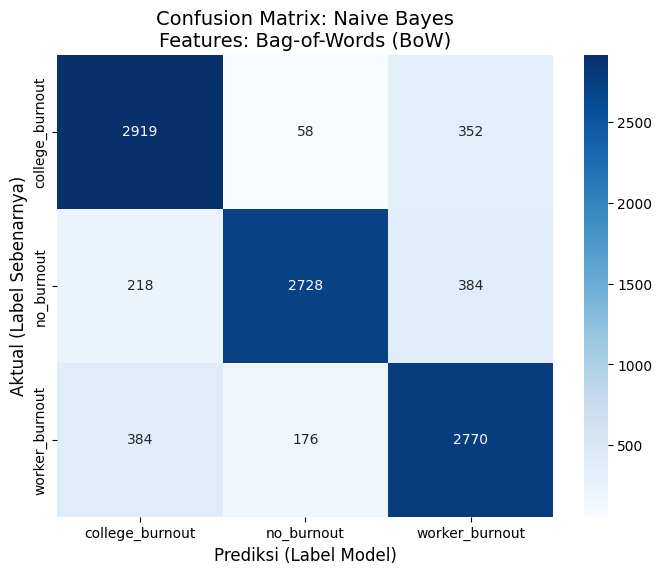



--- MENGGUNAKAN FITUR: TF-IDF (Unigrams) (Bentuk: (39955, 5023)) ---

  📊 Naive Bayes + TF-IDF (Unigrams)
  Sedang melatih Naive Bayes...
  Melakukan prediksi...

  Laporan Klasifikasi (Naive Bayes + TF-IDF (Unigrams)):
                 precision    recall  f1-score   support

college_burnout       0.83      0.88      0.85      3329
     no_burnout       0.91      0.83      0.87      3330
 worker_burnout       0.80      0.81      0.80      3330

       accuracy                           0.84      9989
      macro avg       0.84      0.84      0.84      9989
   weighted avg       0.84      0.84      0.84      9989

  Waktu eksekusi: 0.01 detik


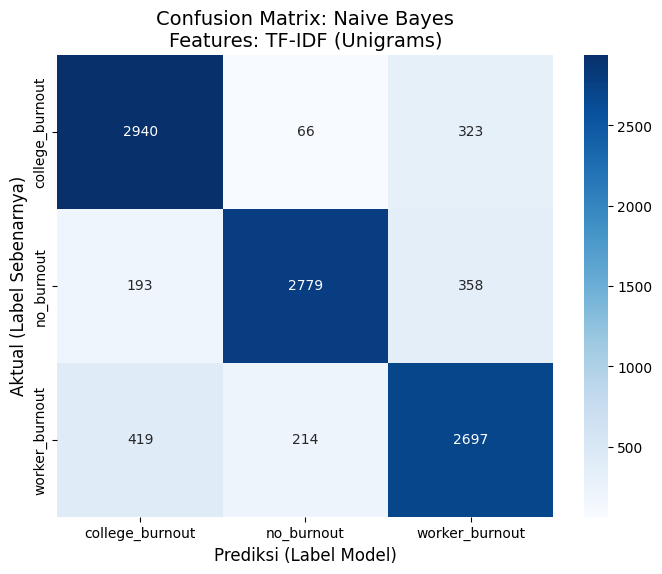



--- MENGGUNAKAN FITUR: TF-IDF (N-grams) (Bentuk: (39955, 15000)) ---

  📊 Naive Bayes + TF-IDF (N-grams)
  Sedang melatih Naive Bayes...
  Melakukan prediksi...

  Laporan Klasifikasi (Naive Bayes + TF-IDF (N-grams)):
                 precision    recall  f1-score   support

college_burnout       0.83      0.90      0.86      3329
     no_burnout       0.97      0.81      0.88      3330
 worker_burnout       0.79      0.86      0.82      3330

       accuracy                           0.85      9989
      macro avg       0.86      0.85      0.86      9989
   weighted avg       0.86      0.85      0.86      9989

  Waktu eksekusi: 0.01 detik


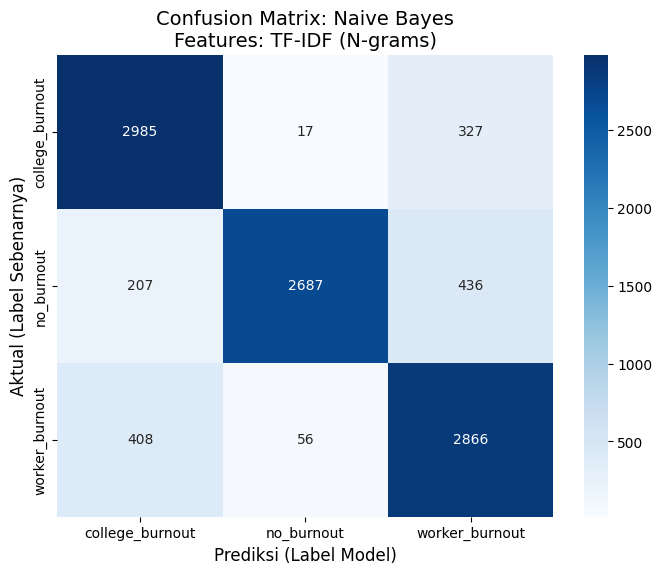



--- MENGGUNAKAN FITUR: LDA Features (Bentuk: (39955, 15)) ---

  📊 Naive Bayes + LDA Features
  Sedang melatih Naive Bayes...
  Melakukan prediksi...

  Laporan Klasifikasi (Naive Bayes + LDA Features):
                 precision    recall  f1-score   support

college_burnout       0.46      0.54      0.50      3329
     no_burnout       0.38      0.29      0.33      3330
 worker_burnout       0.43      0.46      0.45      3330

       accuracy                           0.43      9989
      macro avg       0.42      0.43      0.42      9989
   weighted avg       0.42      0.43      0.42      9989

  Waktu eksekusi: 0.01 detik


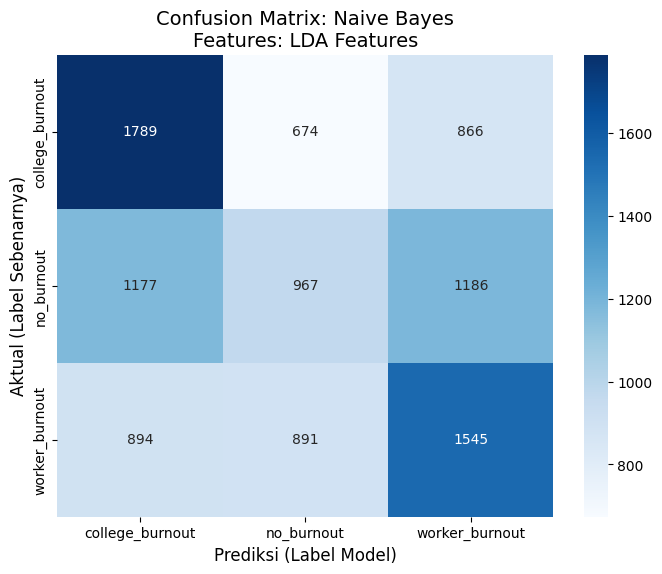

In [16]:
# ==========================================
# 14. Eksekusi Pelatihan & Evaluasi (Nested Loop)
# ==========================================
print("\n\n==============================================")
print("🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)")
print("==============================================")

# --- PENGATURAN VISUALISASI ---
# Setel ke False jika Anda tidak ingin 20 plot membanjiri notebook Anda
TAMPILKAN_CONFUSION_MATRIX = True

# Pastikan variabel y_train, y_test, le ada
try:
    # Loop untuk setiap metode feature extraction
    for method_name, (X_train_feat, X_test_feat) in feature_sets.items():
        print(f"\n\n--- MENGGUNAKAN FITUR: {method_name} (Bentuk: {X_train_feat.shape}) ---")

        # Loop untuk setiap model
        for model_name, model in models.items():

            print(f"\n  ==========================================")
            print(f"  📊 {model_name} + {method_name}")
            print(f"  ==========================================")

            start_time = time.time()

            # 1. Latih model
            print(f"  Sedang melatih {model_name}...")
            from sklearn.base import clone
            model_instance = clone(model)

            model_instance.fit(X_train_feat, y_train)

            # 2. Prediksi
            print(f"  Melakukan prediksi...")
            y_pred = model_instance.predict(X_test_feat)

            end_time = time.time()

            # 3. Tampilkan Laporan Klasifikasi
            print(f"\n  Laporan Klasifikasi ({model_name} + {method_name}):")
            report = classification_report(
                y_test,
                y_pred,
                target_names=le.classes_,  # Menggunakan LabelEncoder 'le'
                zero_division=0
            )
            print(report)
            print(f"  Waktu eksekusi: {end_time - start_time:.2f} detik")

            # ==========================================
            # 4. TAMBAHAN: Visualisasi Confusion Matrix
            # ==========================================
            if TAMPILKAN_CONFUSION_MATRIX:
                try:
                    cm = confusion_matrix(y_test, y_pred)
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                xticklabels=le.classes_,
                                yticklabels=le.classes_)
                    plt.title(f'Confusion Matrix: {model_name}\nFeatures: {method_name}', fontsize=14)
                    plt.ylabel('Aktual (Label Sebenarnya)', fontsize=12)
                    plt.xlabel('Prediksi (Label Model)', fontsize=12)
                    plt.show()
                except Exception as e:
                    print(f"  (Gagal membuat confusion matrix: {e})")

except NameError as e:
    print(f"\n❌ ERROR: Variabel tidak ditemukan: {e}")
    print("Pastikan Anda telah menjalankan sel kode sebelumnya yang mendefinisikan variabel 'le', 'y_train', 'y_test', dan semua 'X_train_*'.")
except Exception as e:
    print(f"\n❌ ERROR LAIN TERJADI: {e}")

**Error Analysis (Naive Bayes)**

🚀 Memulai Analisis Kesalahan untuk: Naive Bayes + Bag-of-Words (BoW)
Sedang melatih ulang Naive Bayes...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 1572 (15.74%)
Jumlah kebenaran prediksi: 8417 (84.26%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0          58             352
no_burnout                               218           0             384
worker_burnout                           384         176               0


Visualisasi Matriks KESALAHAN:


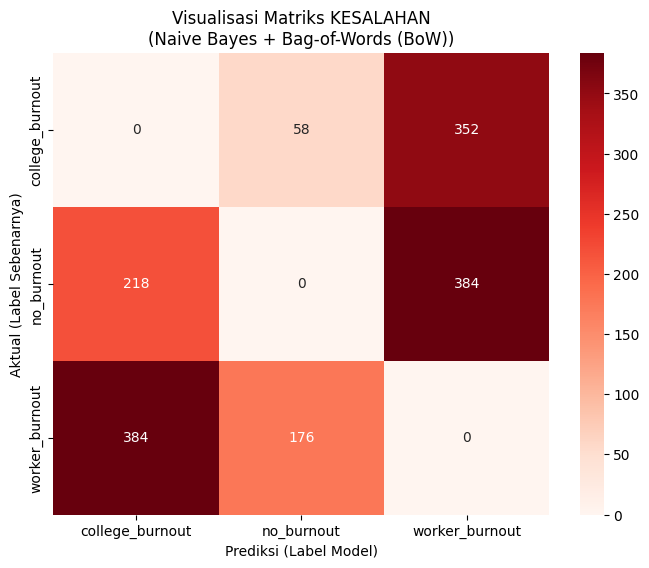


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         2919           0               0
no_burnout                                 0        2728               0
worker_burnout                             0           0            2770


Visualisasi Matriks KEBENARAN:


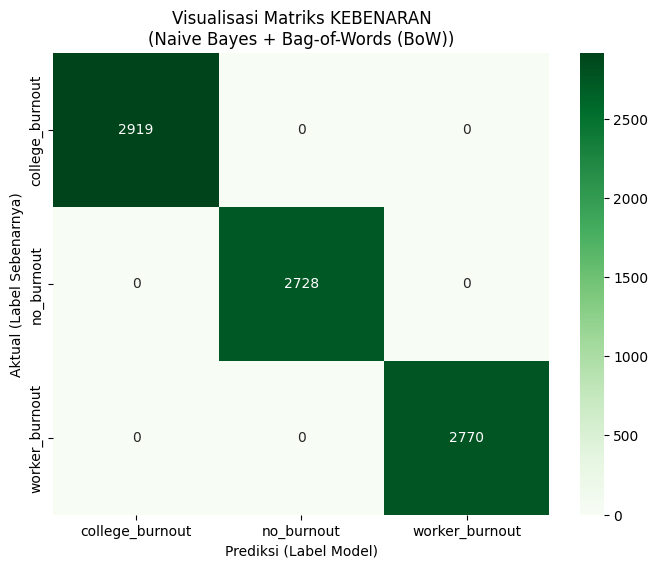


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
7                                                                                                            feel bit crappy still saturday think stress something   
12                                                                                                                             tired feeling awkward around people   
24                                                                                                                                  feel successful happy progress   
28                                                                                                                                feel deprived hungry like manage   
29                                                                                                ive left run feeling agitated something time get back ive worked   
44                                                                                                                                    wa feeling really inadequate   
54                                                                                                                             feeling pretty lethargic long drive   
61                                                                                                                                    must admit feel disheartened   
70                                                                                                                              already feeling like le productive   
72                                                                                                                                            feel like bit boring   
76                                                                                                                  wa day today fourth day still feeling horrible   
77                                                                                                                          appreciate reaching making feel valued   
79                                                                                                                                 feel like get blamed everything   
90                                                                                                                       feel empty like nothing waiting put paper   
93                                                                                                                                feel determined great programmer   
94                                                                                    running low sleep feel lethargic useless carry anything cognitively involved   
98                                                                feel like opportunity everything gives opportunity suck everything convinced expected everything   
100                                                                                                            guys apparently fucking tired right feeling useless   
102  put much pressure meet target different area life feel something ha suffer something else successful despite trying maintain balance effort course consistent   
109                                                                                          find feeling way remind question anxiety usually lead anywhere useful   
127                                                                                                                             give much work still feeling blank   
148                                                                 lool seriously get mad poutingface poutingface poutingface poutingface poutingface poutingface   
152                                                                                                                            need feel like something worthwhile   
163                                                       want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
167     

In [17]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Naive Bayes"
NAMA_FITUR_ANALISIS = "Bag-of-Words (BoW)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Naive Bayes + TF-IDF (Unigrams)
Sedang melatih ulang Naive Bayes...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 1573 (15.75%)
Jumlah kebenaran prediksi: 8416 (84.25%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0          66             323
no_burnout                               193           0             358
worker_burnout                           419         214               0


Visualisasi Matriks KESALAHAN:


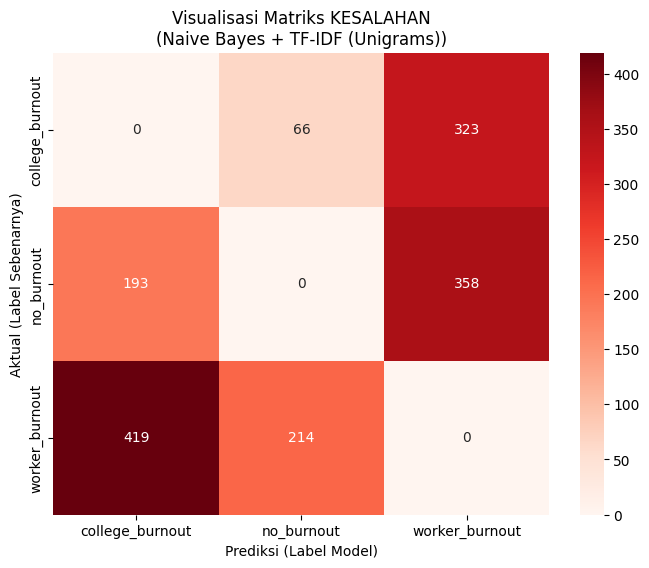


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         2940           0               0
no_burnout                                 0        2779               0
worker_burnout                             0           0            2697


Visualisasi Matriks KEBENARAN:


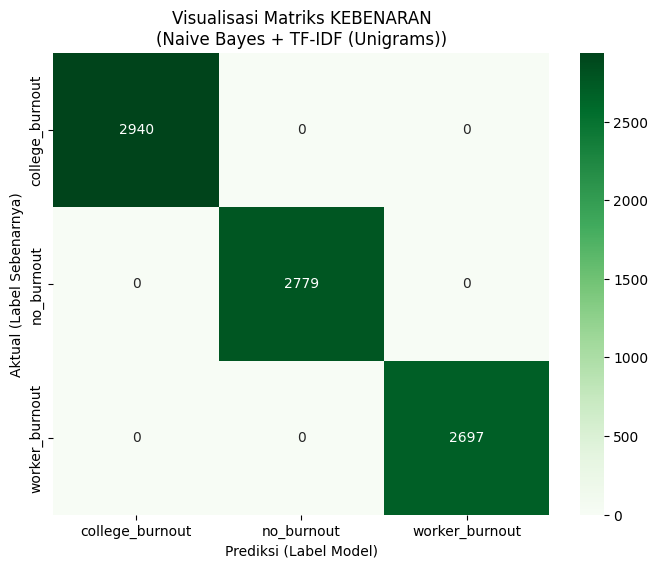


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
7                                                                                                            feel bit crappy still saturday think stress something   
12                                                                                                                             tired feeling awkward around people   
24                                                                                                                                  feel successful happy progress   
28                                                                                                                                feel deprived hungry like manage   
29                                                                                                ive left run feeling agitated something time get back ive worked   
37                                                                                                                               feel really burdened pressed time   
44                                                                                                                                    wa feeling really inadequate   
61                                                                                                                                    must admit feel disheartened   
70                                                                                                                              already feeling like le productive   
72                                                                                                                                            feel like bit boring   
76                                                                                                                  wa day today fourth day still feeling horrible   
77                                                                                                                          appreciate reaching making feel valued   
79                                                                                                                                 feel like get blamed everything   
90                                                                                                                       feel empty like nothing waiting put paper   
93                                                                                                                                feel determined great programmer   
94                                                                                    running low sleep feel lethargic useless carry anything cognitively involved   
98                                                                feel like opportunity everything gives opportunity suck everything convinced expected everything   
100                                                                                                            guys apparently fucking tired right feeling useless   
102  put much pressure meet target different area life feel something ha suffer something else successful despite trying maintain balance effort course consistent   
109                                                                                          find feeling way remind question anxiety usually lead anywhere useful   
152                                                                                                                            need feel like something worthwhile   
163                                                       want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
167                                                                                                                                                      feel dumb   
168                                                     spent hour pouring enthusiasm sensitivity effort tell story fullness see experience feel drained exhausted   
172     

In [18]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Naive Bayes"
NAMA_FITUR_ANALISIS = "TF-IDF (Unigrams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Naive Bayes + TF-IDF (N-grams)
Sedang melatih ulang Naive Bayes...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 1451 (14.53%)
Jumlah kebenaran prediksi: 8538 (85.47%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0          17             327
no_burnout                               207           0             436
worker_burnout                           408          56               0


Visualisasi Matriks KESALAHAN:


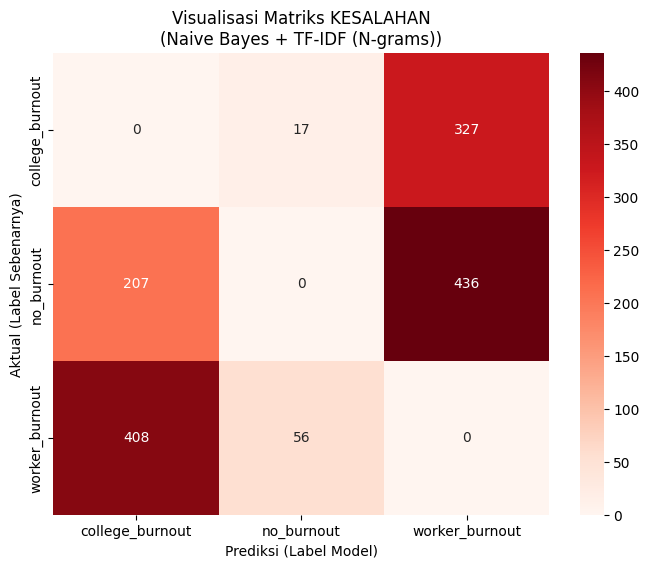


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         2985           0               0
no_burnout                                 0        2687               0
worker_burnout                             0           0            2866


Visualisasi Matriks KEBENARAN:


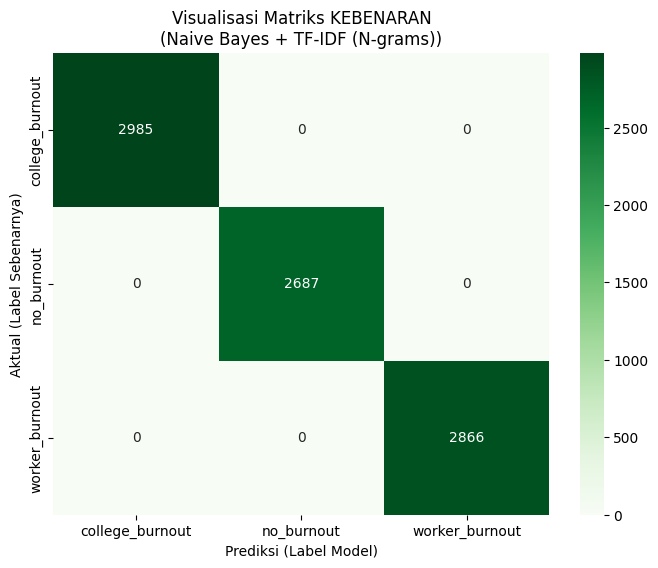


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
0                                                                                                                                                feel doomed alone   
7                                                                                                            feel bit crappy still saturday think stress something   
9                                                                                                      wa starting feel defeated wa major attitude adjustment week   
24                                                                                                                                  feel successful happy progress   
37                                                                                                                               feel really burdened pressed time   
40                                                                                                                                    im already feeling exhausted   
51                                                                                                                 ive getting mood feel listless energy dont care   
54                                                                                                                             feeling pretty lethargic long drive   
67                                                                                                          feeling wa stubborn actually learn time table properly   
72                                                                                                                                            feel like bit boring   
77                                                                                                                          appreciate reaching making feel valued   
78                                                                                                      feel numb desired college degree rewarding career marriage   
79                                                                                                                                 feel like get blamed everything   
93                                                                                                                                feel determined great programmer   
94                                                                                    running low sleep feel lethargic useless carry anything cognitively involved   
98                                                                feel like opportunity everything gives opportunity suck everything convinced expected everything   
100                                                                                                            guys apparently fucking tired right feeling useless   
102  put much pressure meet target different area life feel something ha suffer something else successful despite trying maintain balance effort course consistent   
109                                                                                          find feeling way remind question anxiety usually lead anywhere useful   
127                                                                                                                             give much work still feeling blank   
141                                                                                                                               feel deserve sincere confronting   
148                                                                 lool seriously get mad poutingface poutingface poutingface poutingface poutingface poutingface   
152                                                                                                                            need feel like something worthwhile   
163                                                       want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
167     

In [19]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Naive Bayes"
NAMA_FITUR_ANALISIS = "TF-IDF (N-grams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Naive Bayes + LDA Features
Sedang melatih ulang Naive Bayes...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 5688 (56.94%)
Jumlah kebenaran prediksi: 4301 (43.06%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0         674             866
no_burnout                              1177           0            1186
worker_burnout                           894         891               0


Visualisasi Matriks KESALAHAN:


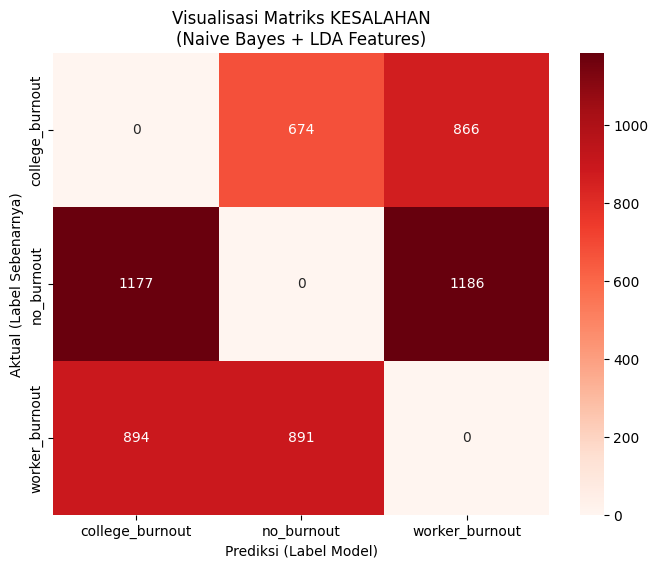


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         1789           0               0
no_burnout                                 0         967               0
worker_burnout                             0           0            1545


Visualisasi Matriks KEBENARAN:


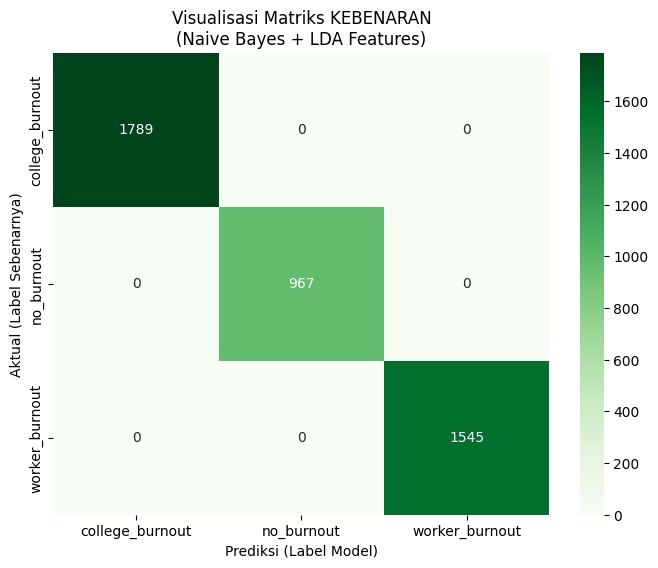


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
0                                                                                                                             feel doomed alone   
1                                                         used constantly working schoolwork weekend feel almost lost nothing specific get done   
5                                                                                                 mean feel really relaxed concentration jumped   
7                                                                                         feel bit crappy still saturday think stress something   
8                                                                                                                       feel intensely peaceful   
9                                                                                   wa starting feel defeated wa major attitude adjustment week   
15                                                                                                                      hour minutes class left   
16                                                                         dont see end sight annoy pressure feel productive balance everything   
19  try one last attempt fight feeling wa unpleasant unknown try trance self sleep picturing darkness shedding thought reason becoming one void   
21                                                                    really feel awful want lose audience blogging gives good confidence boost   
22                                                                                       going feel treat opportunity pursue creative endeavors   
24                                                                                                               feel successful happy progress   
26                                                                                        feel unloved mad put position expect different better   
28                                                                                                             feel deprived hungry like manage   
29                                                                             ive left run feeling agitated something time get back ive worked   
32                                                                                                    tired since moved months ago feel drained   
34                                                                                        feel unloved mad put position expect different better   
35                                                                                                     day made small thoughts surprises others   
40                                                                                                                 im already feeling exhausted   
42                                                         feeling find bit ungrateful competitive get london med schools gave first choice job   
45                                                                                                          suppose feeling pretty good settled   
47                                                                                                                      feel rather sympathetic   
48                                                               clearly see pattern feeling exhausted often connected cycle ovulation included   
51                                                                                              ive getting mood feel listless energy dont care   
53                                                               im hoping calm storm feel really peaceful relaxed even look ahead thing coming   

         label_asli   prediksi_model  
0        no_burnout  college_burnout  
1   college_burnout       no_burnout  
5        no_burnout   worker_burnout  
7    worker_burnout  college_burnout  
8        no_burnout  college_burnout  
9        no_burnout  college_burnout  
15  college_burnout       no_burnout  
16  

In [20]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Naive Bayes"
NAMA_FITUR_ANALISIS = "LDA Features"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

**Mendefinisikan Model (XGBoost)**

In [21]:
# ==========================================
# 12. Definisikan Model yang Akan Digunakan
# ==========================================
print("\n🧠 Mendefinisikan model klasifikasi...")
models = {
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
}


🧠 Mendefinisikan model klasifikasi...


**Pelatihan dan Evaluasi (XGBoost)**



🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)


--- MENGGUNAKAN FITUR: Bag-of-Words (BoW) (Bentuk: (39955, 5023)) ---

  📊 XGBoost + Bag-of-Words (BoW)
  Sedang melatih XGBoost...
  Melakukan prediksi...

  Laporan Klasifikasi (XGBoost + Bag-of-Words (BoW)):
                 precision    recall  f1-score   support

college_burnout       0.90      0.82      0.86      3329
     no_burnout       0.80      0.97      0.88      3330
 worker_burnout       0.87      0.76      0.81      3330

       accuracy                           0.85      9989
      macro avg       0.86      0.85      0.85      9989
   weighted avg       0.86      0.85      0.85      9989

  Waktu eksekusi: 4.32 detik


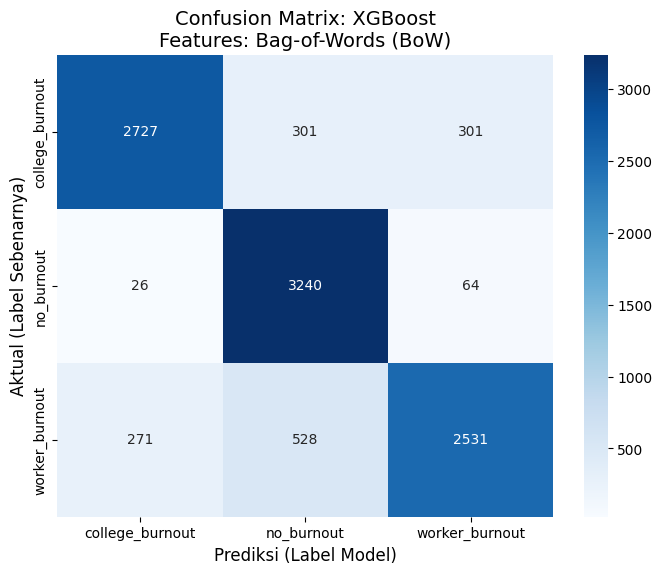



--- MENGGUNAKAN FITUR: TF-IDF (Unigrams) (Bentuk: (39955, 5023)) ---

  📊 XGBoost + TF-IDF (Unigrams)
  Sedang melatih XGBoost...
  Melakukan prediksi...

  Laporan Klasifikasi (XGBoost + TF-IDF (Unigrams)):
                 precision    recall  f1-score   support

college_burnout       0.90      0.83      0.87      3329
     no_burnout       0.81      0.99      0.89      3330
 worker_burnout       0.89      0.77      0.83      3330

       accuracy                           0.86      9989
      macro avg       0.87      0.86      0.86      9989
   weighted avg       0.87      0.86      0.86      9989

  Waktu eksekusi: 21.19 detik


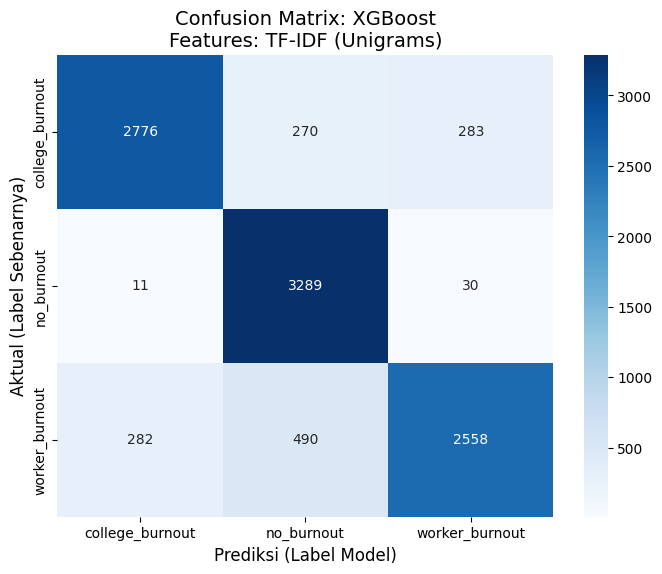



--- MENGGUNAKAN FITUR: TF-IDF (N-grams) (Bentuk: (39955, 15000)) ---

  📊 XGBoost + TF-IDF (N-grams)
  Sedang melatih XGBoost...
  Melakukan prediksi...

  Laporan Klasifikasi (XGBoost + TF-IDF (N-grams)):
                 precision    recall  f1-score   support

college_burnout       0.91      0.83      0.87      3329
     no_burnout       0.83      0.99      0.90      3330
 worker_burnout       0.88      0.79      0.83      3330

       accuracy                           0.87      9989
      macro avg       0.87      0.87      0.87      9989
   weighted avg       0.87      0.87      0.87      9989

  Waktu eksekusi: 33.97 detik


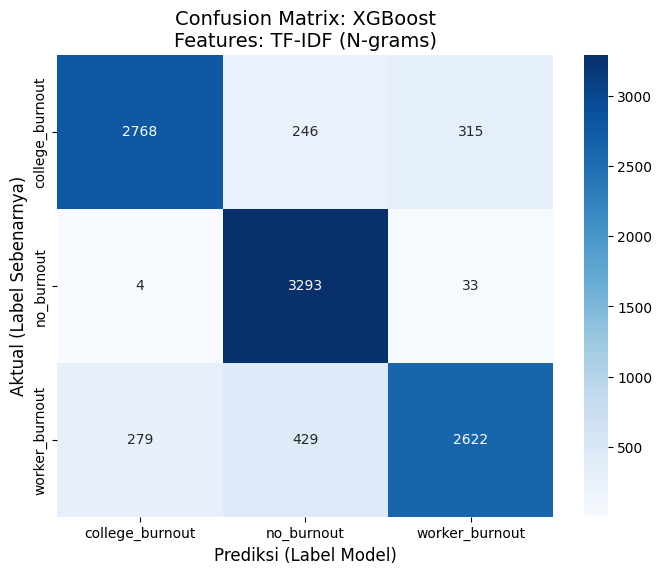



--- MENGGUNAKAN FITUR: LDA Features (Bentuk: (39955, 15)) ---

  📊 XGBoost + LDA Features
  Sedang melatih XGBoost...
  Melakukan prediksi...

  Laporan Klasifikasi (XGBoost + LDA Features):
                 precision    recall  f1-score   support

college_burnout       0.79      0.79      0.79      3329
     no_burnout       0.86      0.92      0.89      3330
 worker_burnout       0.78      0.73      0.75      3330

       accuracy                           0.81      9989
      macro avg       0.81      0.81      0.81      9989
   weighted avg       0.81      0.81      0.81      9989

  Waktu eksekusi: 1.73 detik


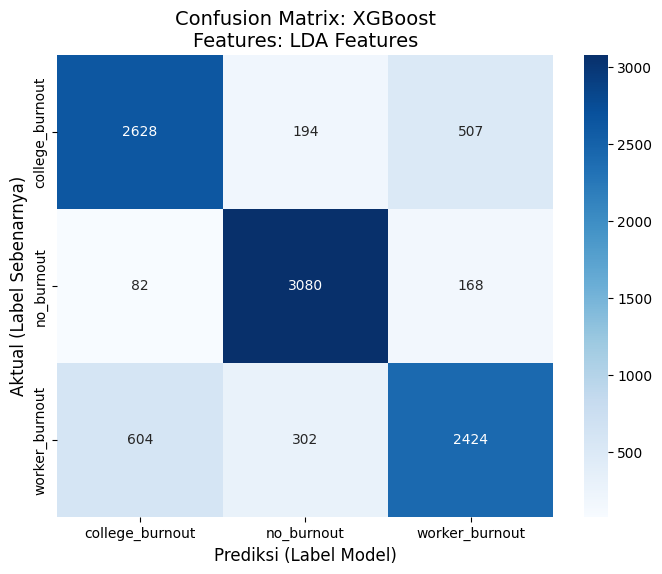

In [22]:
# ==========================================
# 14. Eksekusi Pelatihan & Evaluasi (Nested Loop)
# ==========================================
print("\n\n==============================================")
print("🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)")
print("==============================================")

# --- PENGATURAN VISUALISASI ---
# Setel ke False jika Anda tidak ingin 20 plot membanjiri notebook Anda
TAMPILKAN_CONFUSION_MATRIX = True

# Pastikan variabel y_train, y_test, le ada
try:
    # Loop untuk setiap metode feature extraction
    for method_name, (X_train_feat, X_test_feat) in feature_sets.items():
        print(f"\n\n--- MENGGUNAKAN FITUR: {method_name} (Bentuk: {X_train_feat.shape}) ---")

        # Loop untuk setiap model
        for model_name, model in models.items():

            print(f"\n  ==========================================")
            print(f"  📊 {model_name} + {method_name}")
            print(f"  ==========================================")

            start_time = time.time()

            # 1. Latih model
            print(f"  Sedang melatih {model_name}...")
            from sklearn.base import clone
            model_instance = clone(model)

            model_instance.fit(X_train_feat, y_train)

            # 2. Prediksi
            print(f"  Melakukan prediksi...")
            y_pred = model_instance.predict(X_test_feat)

            end_time = time.time()

            # 3. Tampilkan Laporan Klasifikasi
            print(f"\n  Laporan Klasifikasi ({model_name} + {method_name}):")
            report = classification_report(
                y_test,
                y_pred,
                target_names=le.classes_,  # Menggunakan LabelEncoder 'le'
                zero_division=0
            )
            print(report)
            print(f"  Waktu eksekusi: {end_time - start_time:.2f} detik")

            # ==========================================
            # 4. TAMBAHAN: Visualisasi Confusion Matrix
            # ==========================================
            if TAMPILKAN_CONFUSION_MATRIX:
                try:
                    cm = confusion_matrix(y_test, y_pred)
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                xticklabels=le.classes_,
                                yticklabels=le.classes_)
                    plt.title(f'Confusion Matrix: {model_name}\nFeatures: {method_name}', fontsize=14)
                    plt.ylabel('Aktual (Label Sebenarnya)', fontsize=12)
                    plt.xlabel('Prediksi (Label Model)', fontsize=12)
                    plt.show()
                except Exception as e:
                    print(f"  (Gagal membuat confusion matrix: {e})")

except NameError as e:
    print(f"\n❌ ERROR: Variabel tidak ditemukan: {e}")
    print("Pastikan Anda telah menjalankan sel kode sebelumnya yang mendefinisikan variabel 'le', 'y_train', 'y_test', dan semua 'X_train_*'.")
except Exception as e:
    print(f"\n❌ ERROR LAIN TERJADI: {e}")

**Error Analysis (XGBoost)**

🚀 Memulai Analisis Kesalahan untuk: XGBoost + Bag-of-Words (BoW)
Sedang melatih ulang XGBoost...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 1491 (14.93%)
Jumlah kebenaran prediksi: 8498 (85.07%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0         301             301
no_burnout                                26           0              64
worker_burnout                           271         528               0


Visualisasi Matriks KESALAHAN:


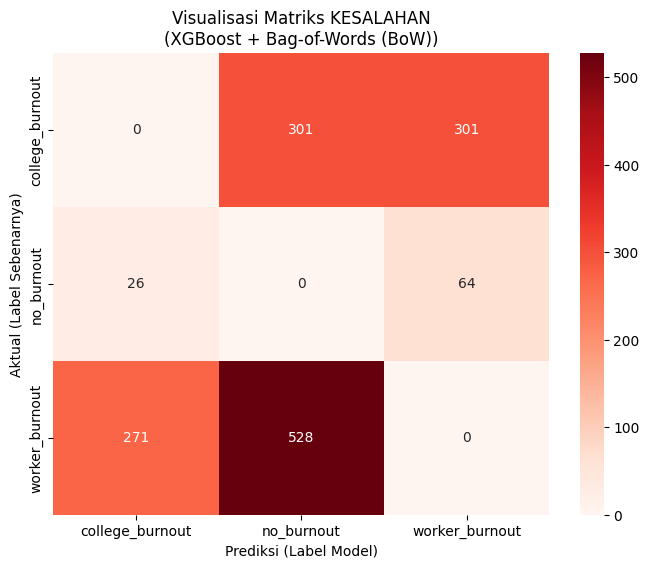


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         2727           0               0
no_burnout                                 0        3240               0
worker_burnout                             0           0            2531


Visualisasi Matriks KEBENARAN:


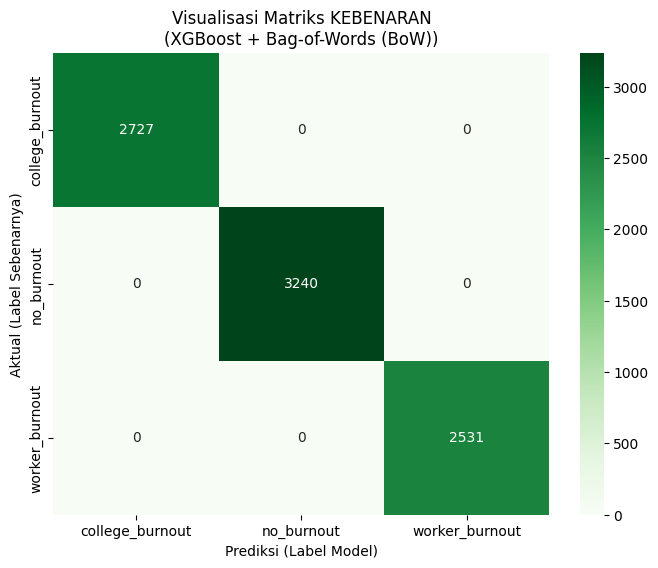


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
3                                                          feel fake like talent gift next person imposter waiting found cant cant make thing happen cant whatever   
7                                                                                                            feel bit crappy still saturday think stress something   
12                                                                                                                             tired feeling awkward around people   
32                                                                                                                       tired since moved months ago feel drained   
37                                                                                                                               feel really burdened pressed time   
41                                                                                                             know ive hit low point feeling weepy cleaning house   
62                                                                                                     feel like important responsibility wife homemaker suffering   
65                                                             feeling doomed taking panicked implications trying adjust idea also responsible massive undertaking   
70                                                                                                                              already feeling like le productive   
73                                                                 feel eager get diploma done feeling lasts know ill regret even thinking start working full time   
75                                                                            feel thoroughly unwelcome school individual people clearly deeply moved work choices   
76                                                                                                                  wa day today fourth day still feeling horrible   
85                                                                                                           wanted benefit service yet feel even deprived muddled   
86                                                                                                                        gotta ewrt outline tennis work need time   
88                                                                                                 get upset educational inequity feel entirely helpless lose shit   
91                                                                                      already feeling aching tight shoulder already ever since tuition came back   
93                                                                                                                                feel determined great programmer   
100                                                                                                            guys apparently fucking tired right feeling useless   
101                                                                                                                                  get bad feel hopeless control   
102  put much pressure meet target different area life feel something ha suffer something else successful despite trying maintain balance effort course consistent   
118                                                                                                                         gave feel might fail cad cant bothered   
120                                                 may setbacks past optimism encourages pick dust learn experiences every failure lesson towards greater success   
127                                                                                                                             give much work still feeling blank   
136                                                                                   running low sleep feel lethargic useless carry anything cognitively involved   
150     

In [23]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "XGBoost"
NAMA_FITUR_ANALISIS = "Bag-of-Words (BoW)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: XGBoost + TF-IDF (Unigrams)
Sedang melatih ulang XGBoost...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 1366 (13.68%)
Jumlah kebenaran prediksi: 8623 (86.32%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0         270             283
no_burnout                                11           0              30
worker_burnout                           282         490               0


Visualisasi Matriks KESALAHAN:


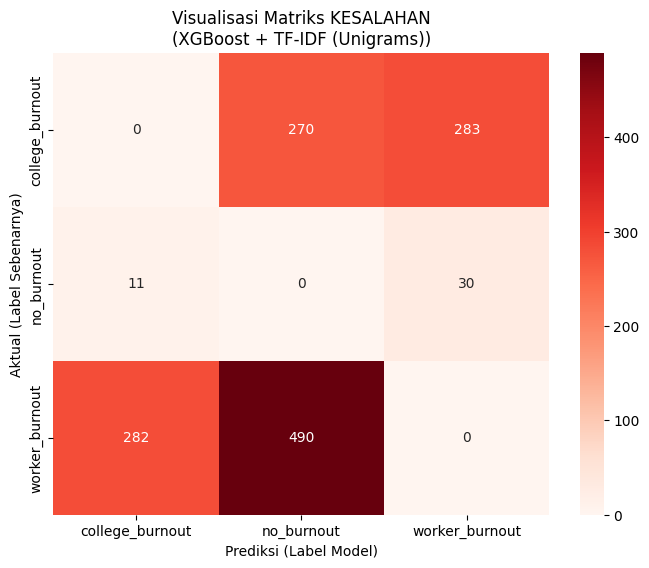


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         2776           0               0
no_burnout                                 0        3289               0
worker_burnout                             0           0            2558


Visualisasi Matriks KEBENARAN:


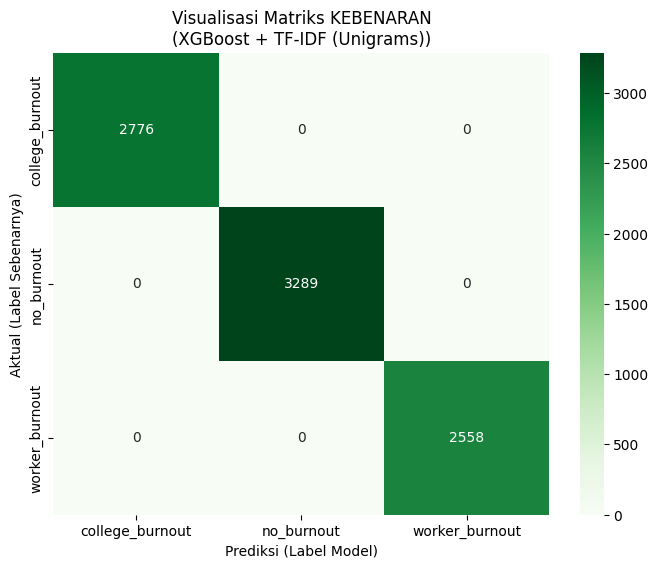


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
1                                                                      used constantly working schoolwork weekend feel almost lost nothing specific get done   
3                                                    feel fake like talent gift next person imposter waiting found cant cant make thing happen cant whatever   
12                                                                                                                       tired feeling awkward around people   
41                                                                                                       know ive hit low point feeling weepy cleaning house   
51                                                                                                           ive getting mood feel listless energy dont care   
62                                                                                               feel like important responsibility wife homemaker suffering   
65                                                       feeling doomed taking panicked implications trying adjust idea also responsible massive undertaking   
70                                                                                                                        already feeling like le productive   
73                                                           feel eager get diploma done feeling lasts know ill regret even thinking start working full time   
76                                                                                                            wa day today fourth day still feeling horrible   
85                                                                                                     wanted benefit service yet feel even deprived muddled   
86                                                                                                                  gotta ewrt outline tennis work need time   
88                                                                                           get upset educational inequity feel entirely helpless lose shit   
91                                                                                already feeling aching tight shoulder already ever since tuition came back   
93                                                                                                                          feel determined great programmer   
100                                                                                                      guys apparently fucking tired right feeling useless   
101                                                                                                                            get bad feel hopeless control   
118                                                                                                                   gave feel might fail cad cant bothered   
120                                           may setbacks past optimism encourages pick dust learn experiences every failure lesson towards greater success   
127                                                                                                                       give much work still feeling blank   
136                                                                             running low sleep feel lethargic useless carry anything cognitively involved   
150  happy would like feel free experiment applying interviewing different occupations different fields order find really wanting retire need change careers   
168                                               spent hour pouring enthusiasm sensitivity effort tell story fullness see experience feel drained exhausted   
169                                                                                                                  look back feel privileged made industry   
176                                           desire success allconsuming driving individuals work long hours sacrifice personal relationships pursuit g

In [24]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "XGBoost"
NAMA_FITUR_ANALISIS = "TF-IDF (Unigrams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: XGBoost + TF-IDF (N-grams)
Sedang melatih ulang XGBoost...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 1306 (13.07%)
Jumlah kebenaran prediksi: 8683 (86.93%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0         246             315
no_burnout                                 4           0              33
worker_burnout                           279         429               0


Visualisasi Matriks KESALAHAN:


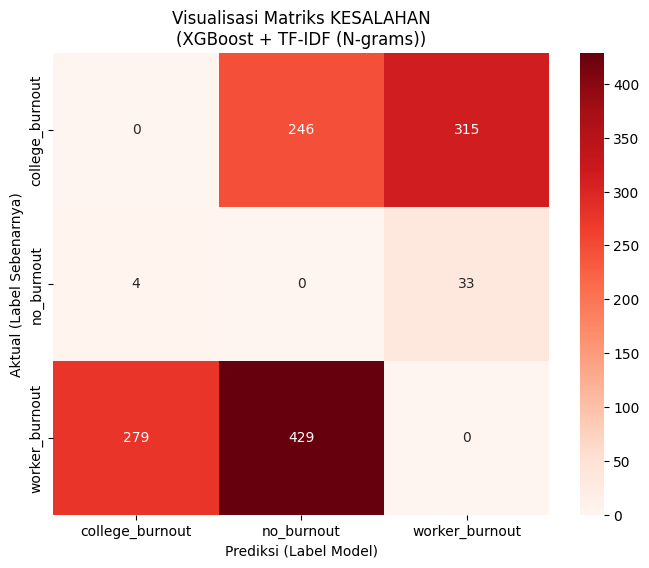


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         2768           0               0
no_burnout                                 0        3293               0
worker_burnout                             0           0            2622


Visualisasi Matriks KEBENARAN:


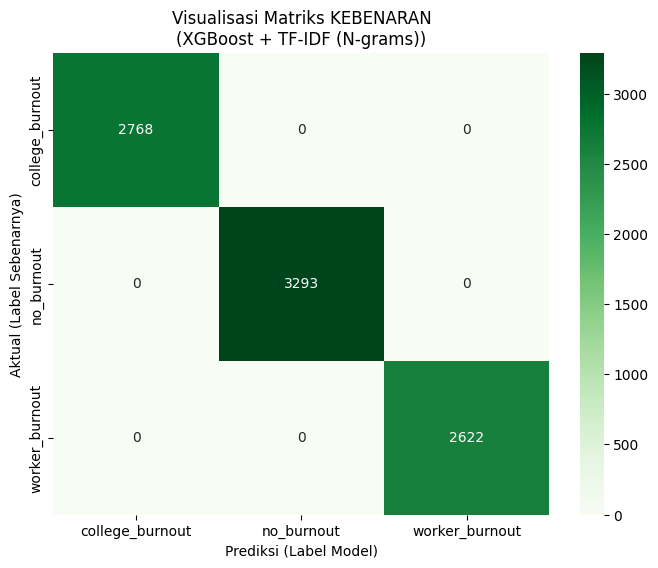


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
1                                                                      used constantly working schoolwork weekend feel almost lost nothing specific get done   
3                                                    feel fake like talent gift next person imposter waiting found cant cant make thing happen cant whatever   
12                                                                                                                       tired feeling awkward around people   
41                                                                                                       know ive hit low point feeling weepy cleaning house   
51                                                                                                           ive getting mood feel listless energy dont care   
62                                                                                               feel like important responsibility wife homemaker suffering   
65                                                       feeling doomed taking panicked implications trying adjust idea also responsible massive undertaking   
70                                                                                                                        already feeling like le productive   
75                                                                      feel thoroughly unwelcome school individual people clearly deeply moved work choices   
76                                                                                                            wa day today fourth day still feeling horrible   
85                                                                                                     wanted benefit service yet feel even deprived muddled   
86                                                                                                                  gotta ewrt outline tennis work need time   
88                                                                                           get upset educational inequity feel entirely helpless lose shit   
93                                                                                                                          feel determined great programmer   
100                                                                                                      guys apparently fucking tired right feeling useless   
118                                                                                                                   gave feel might fail cad cant bothered   
127                                                                                                                       give much work still feeling blank   
130                                                  im reading lab manual feel like know apply im reading know tomorrow id freak blank attempt bullshit way   
136                                                                             running low sleep feel lethargic useless carry anything cognitively involved   
150  happy would like feel free experiment applying interviewing different occupations different fields order find really wanting retire need change careers   
156                                            able lot stuff people managed various point life feel missed lot life know current path ticket live live want   
168                                               spent hour pouring enthusiasm sensitivity effort tell story fullness see experience feel drained exhausted   
169                                                                                                                  look back feel privileged made industry   
176                                           desire success allconsuming driving individuals work long hours sacrifice personal relationships pursuit goals   
180                                                                                                       believe emotional component clue feel dissatis

In [25]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "XGBoost"
NAMA_FITUR_ANALISIS = "TF-IDF (N-grams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: XGBoost + LDA Features
Sedang melatih ulang XGBoost...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 1857 (18.59%)
Jumlah kebenaran prediksi: 8132 (81.41%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0         194             507
no_burnout                                82           0             168
worker_burnout                           604         302               0


Visualisasi Matriks KESALAHAN:


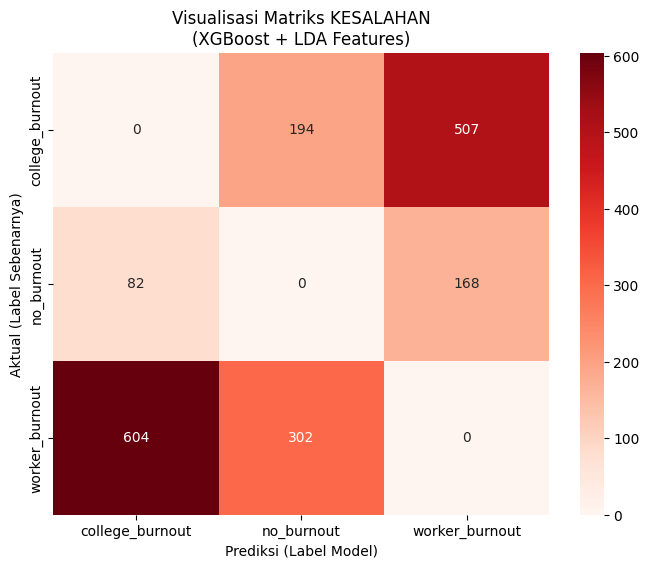


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         2628           0               0
no_burnout                                 0        3080               0
worker_burnout                             0           0            2424


Visualisasi Matriks KEBENARAN:


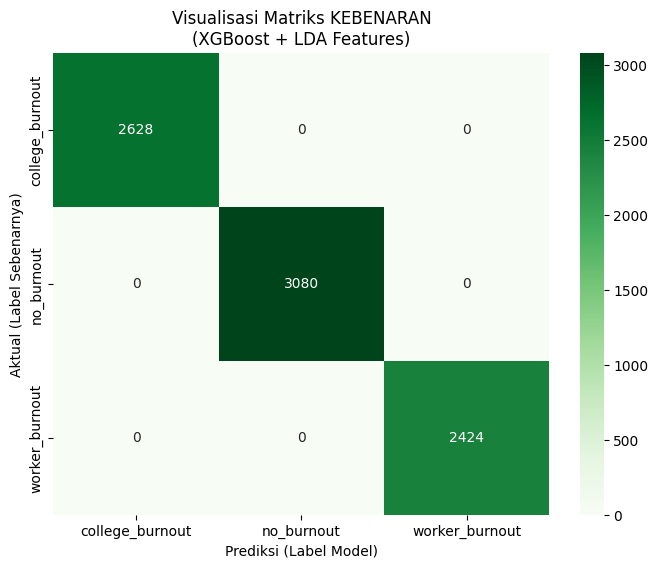


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
2                                                                                     feel like suffering quite bit   
7                                                             feel bit crappy still saturday think stress something   
14                                                                                          working feel determined   
16                                             dont see end sight annoy pressure feel productive balance everything   
26                                                            feel unloved mad put position expect different better   
34                                                            feel unloved mad put position expect different better   
35                                                                         day made small thoughts surprises others   
37                                                                                feel really burdened pressed time   
43                                                    feel sort listless focused right quite frankly easy book read   
46                                                                                             put make feel valued   
50                                                                                        feeling unimportant world   
51                                                                  ive getting mood feel listless energy dont care   
67                                                           feeling wa stubborn actually learn time table properly   
69                                     im feeling pretty mellow today blame carlton draught last night podcast week   
73                  feel eager get diploma done feeling lasts know ill regret even thinking start working full time   
80                                                                      always feel invigorated two monthly classes   
86                                                                         gotta ewrt outline tennis work need time   
94                                     running low sleep feel lethargic useless carry anything cognitively involved   
96                                                          miss home place family resides place love feel welcomed   
100                                                             guys apparently fucking tired right feeling useless   
118                                                                          gave feel might fail cad cant bothered   
120  may setbacks past optimism encourages pick dust learn experiences every failure lesson towards greater success   
127                                                                              give much work still feeling blank   
131                                                                        day made small thoughts surprises others   
134                                                       working started working gym first found feeling energetic   

          label_asli   prediksi_model  
2         no_burnout   worker_burnout  
7     worker_burnout  college_burnout  
14    worker_burnout       no_burnout  
16    worker_burnout  college_burnout  
26    worker_burnout  college_burnout  
34    worker_burnout  college_burnout  
35        no_burnout   worker_burnout  
37    worker_burnout       no_burnout  
43   college_burnout   worker_burnout  
46    worker_burnout       no_burnout  
50    worker_burnout  college_burnout  
51    worker_burnout  college_burnout  
67   college_burnout       no_burnout  
69        no_burnout  college_burnout  
73   college_burnout   worker_burnout  
80   college_burnout       no_burnout  
86   college_burnout   worker_burnout  
94   college_burnout   worker_burnout  
96        no_burnout   worker_burnout  
100  college_burnout   worker_burnout  
118  college_burnout       no_burnout  
120   worker_burnout  college_burnout  
127  college_burnout   worker_burnout  
131       no_burnout   worker_burnout  
134   worker_bur

In [26]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "XGBoost"
NAMA_FITUR_ANALISIS = "LDA Features"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

**Mendefinisikan Model (Logistic Regression)**

In [27]:
# ==========================================
# 12. Definisikan Model yang Akan Digunakan
# ==========================================
print("\n🧠 Mendefinisikan model klasifikasi...")
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
}


🧠 Mendefinisikan model klasifikasi...


**Pelatihan dan Evaluasi (Logistic Regression)**



🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)


--- MENGGUNAKAN FITUR: Bag-of-Words (BoW) (Bentuk: (39955, 5023)) ---

  📊 Logistic Regression + Bag-of-Words (BoW)
  Sedang melatih Logistic Regression...
  Melakukan prediksi...

  Laporan Klasifikasi (Logistic Regression + Bag-of-Words (BoW)):
                 precision    recall  f1-score   support

college_burnout       0.90      0.91      0.90      3329
     no_burnout       0.91      0.97      0.94      3330
 worker_burnout       0.90      0.83      0.86      3330

       accuracy                           0.90      9989
      macro avg       0.90      0.90      0.90      9989
   weighted avg       0.90      0.90      0.90      9989

  Waktu eksekusi: 3.52 detik


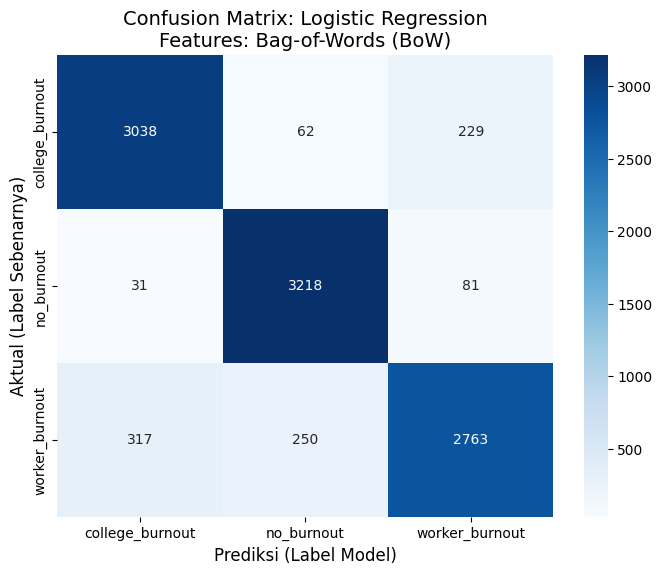



--- MENGGUNAKAN FITUR: TF-IDF (Unigrams) (Bentuk: (39955, 5023)) ---

  📊 Logistic Regression + TF-IDF (Unigrams)
  Sedang melatih Logistic Regression...
  Melakukan prediksi...

  Laporan Klasifikasi (Logistic Regression + TF-IDF (Unigrams)):
                 precision    recall  f1-score   support

college_burnout       0.88      0.90      0.89      3329
     no_burnout       0.90      0.93      0.92      3330
 worker_burnout       0.88      0.82      0.85      3330

       accuracy                           0.89      9989
      macro avg       0.89      0.89      0.89      9989
   weighted avg       0.89      0.89      0.89      9989

  Waktu eksekusi: 2.09 detik


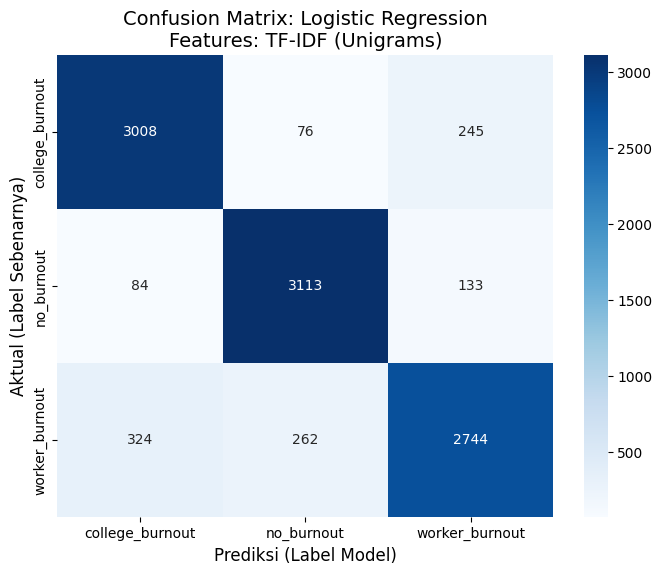



--- MENGGUNAKAN FITUR: TF-IDF (N-grams) (Bentuk: (39955, 15000)) ---

  📊 Logistic Regression + TF-IDF (N-grams)
  Sedang melatih Logistic Regression...
  Melakukan prediksi...

  Laporan Klasifikasi (Logistic Regression + TF-IDF (N-grams)):
                 precision    recall  f1-score   support

college_burnout       0.90      0.92      0.91      3329
     no_burnout       0.93      0.98      0.95      3330
 worker_burnout       0.91      0.85      0.88      3330

       accuracy                           0.92      9989
      macro avg       0.92      0.92      0.92      9989
   weighted avg       0.92      0.92      0.92      9989

  Waktu eksekusi: 2.27 detik


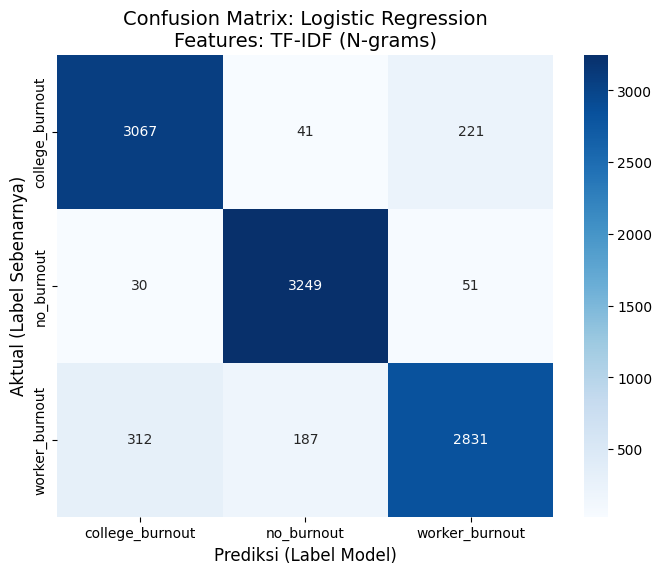



--- MENGGUNAKAN FITUR: LDA Features (Bentuk: (39955, 15)) ---

  📊 Logistic Regression + LDA Features
  Sedang melatih Logistic Regression...
  Melakukan prediksi...

  Laporan Klasifikasi (Logistic Regression + LDA Features):
                 precision    recall  f1-score   support

college_burnout       0.46      0.53      0.49      3329
     no_burnout       0.38      0.29      0.33      3330
 worker_burnout       0.43      0.48      0.45      3330

       accuracy                           0.43      9989
      macro avg       0.43      0.43      0.43      9989
   weighted avg       0.43      0.43      0.43      9989

  Waktu eksekusi: 1.12 detik


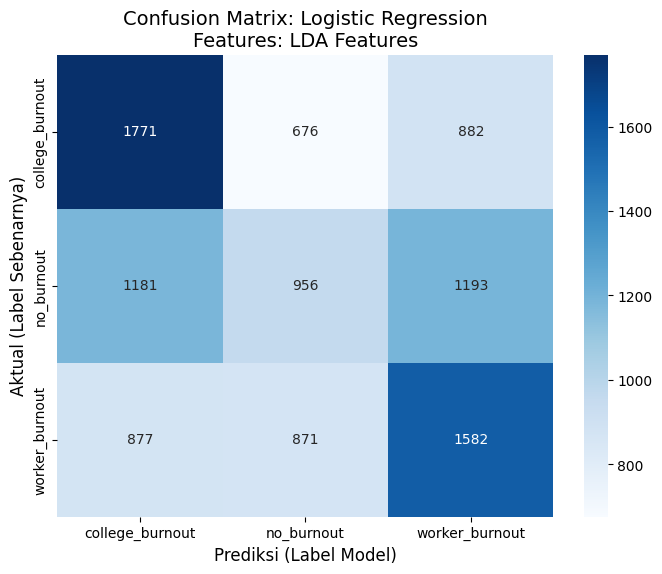

In [28]:
# ==========================================
# 14. Eksekusi Pelatihan & Evaluasi (Nested Loop)
# ==========================================
print("\n\n==============================================")
print("🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)")
print("==============================================")

# --- PENGATURAN VISUALISASI ---
# Setel ke False jika Anda tidak ingin 20 plot membanjiri notebook Anda
TAMPILKAN_CONFUSION_MATRIX = True

# Pastikan variabel y_train, y_test, le ada
try:
    # Loop untuk setiap metode feature extraction
    for method_name, (X_train_feat, X_test_feat) in feature_sets.items():
        print(f"\n\n--- MENGGUNAKAN FITUR: {method_name} (Bentuk: {X_train_feat.shape}) ---")

        # Loop untuk setiap model
        for model_name, model in models.items():

            print(f"\n  ==========================================")
            print(f"  📊 {model_name} + {method_name}")
            print(f"  ==========================================")

            start_time = time.time()

            # 1. Latih model
            print(f"  Sedang melatih {model_name}...")
            from sklearn.base import clone
            model_instance = clone(model)

            model_instance.fit(X_train_feat, y_train)

            # 2. Prediksi
            print(f"  Melakukan prediksi...")
            y_pred = model_instance.predict(X_test_feat)

            end_time = time.time()

            # 3. Tampilkan Laporan Klasifikasi
            print(f"\n  Laporan Klasifikasi ({model_name} + {method_name}):")
            report = classification_report(
                y_test,
                y_pred,
                target_names=le.classes_,  # Menggunakan LabelEncoder 'le'
                zero_division=0
            )
            print(report)
            print(f"  Waktu eksekusi: {end_time - start_time:.2f} detik")

            # ==========================================
            # 4. TAMBAHAN: Visualisasi Confusion Matrix
            # ==========================================
            if TAMPILKAN_CONFUSION_MATRIX:
                try:
                    cm = confusion_matrix(y_test, y_pred)
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                xticklabels=le.classes_,
                                yticklabels=le.classes_)
                    plt.title(f'Confusion Matrix: {model_name}\nFeatures: {method_name}', fontsize=14)
                    plt.ylabel('Aktual (Label Sebenarnya)', fontsize=12)
                    plt.xlabel('Prediksi (Label Model)', fontsize=12)
                    plt.show()
                except Exception as e:
                    print(f"  (Gagal membuat confusion matrix: {e})")

except NameError as e:
    print(f"\n❌ ERROR: Variabel tidak ditemukan: {e}")
    print("Pastikan Anda telah menjalankan sel kode sebelumnya yang mendefinisikan variabel 'le', 'y_train', 'y_test', dan semua 'X_train_*'.")
except Exception as e:
    print(f"\n❌ ERROR LAIN TERJADI: {e}")

**Error Analysis (Logistic Regression)**

🚀 Memulai Analisis Kesalahan untuk: Logistic Regression + Bag-of-Words (BoW)
Sedang melatih ulang Logistic Regression...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 970 (9.71%)
Jumlah kebenaran prediksi: 9019 (90.29%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0          62             229
no_burnout                                31           0              81
worker_burnout                           317         250               0


Visualisasi Matriks KESALAHAN:


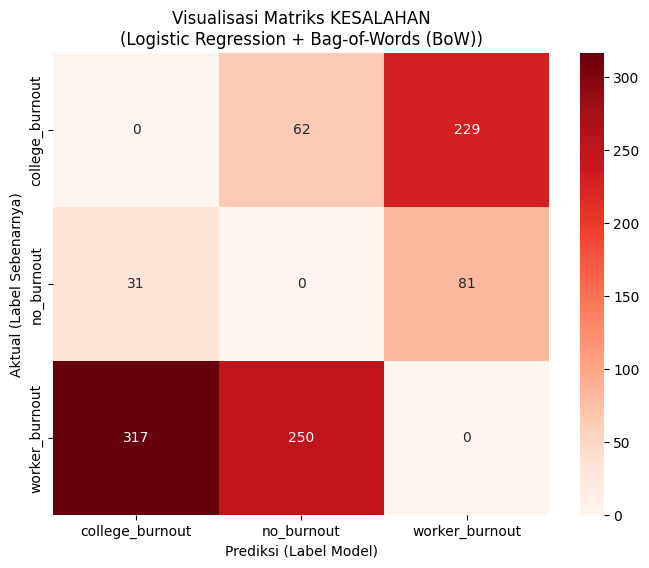


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3038           0               0
no_burnout                                 0        3218               0
worker_burnout                             0           0            2763


Visualisasi Matriks KEBENARAN:


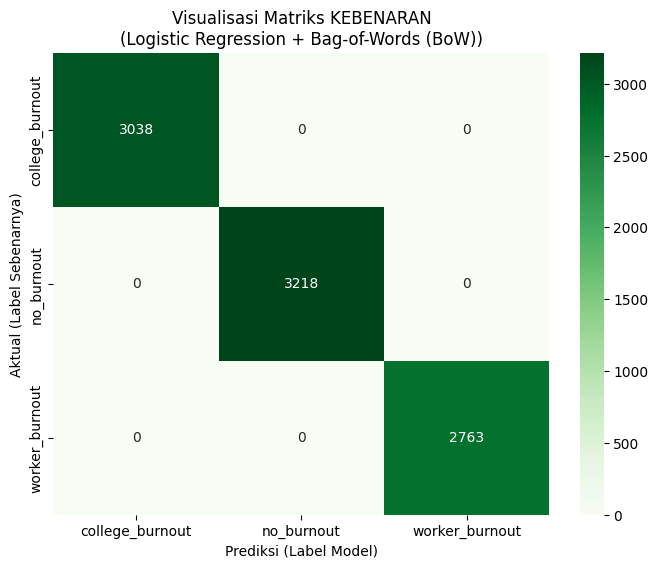


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
7                                                             feel bit crappy still saturday think stress something   
12                                                                              tired feeling awkward around people   
37                                                                                feel really burdened pressed time   
54                                                                              feeling pretty lethargic long drive   
70                                                                               already feeling like le productive   
76                                                                   wa day today fourth day still feeling horrible   
77                                                                           appreciate reaching making feel valued   
78                                                       feel numb desired college degree rewarding career marriage   
86                                                                         gotta ewrt outline tennis work need time   
93                                                                                 feel determined great programmer   
100                                                             guys apparently fucking tired right feeling useless   
120  may setbacks past optimism encourages pick dust learn experiences every failure lesson towards greater success   
127                                                                              give much work still feeling blank   
136                                    running low sleep feel lethargic useless carry anything cognitively involved   
163        want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
180                                                              believe emotional component clue feel dissatisfied   
183                                             burnt yet definitely feeling little singed around edge touch cranky   
188                                                                                     feel really hopeful rd year   
203                                                    feel remind people still exhausted actually still recovering   
223                                                                                         bake feel less stressed   
231                                               wa overwhelmed feeling restlessness convinced worst human emotion   
232                                                                         running really late work feeling groggy   
239                                                                                        dont know feel irritated   
259                   arrived work time focus mind things feelings still making feel horribly lethargic unmotivated   
263                                 know lot related hormones making feel emotional apparently deal excess emotions   

          label_asli   prediksi_model  
7     worker_burnout  college_burnout  
12   college_burnout       no_burnout  
37    worker_burnout  college_burnout  
54    worker_burnout  college_burnout  
70   college_burnout   worker_burnout  
76    worker_burnout       no_burnout  
77        no_burnout   worker_burnout  
78    worker_burnout  college_burnout  
86   college_burnout   worker_burnout  
93    worker_burnout       no_burnout  
100  college_burnout   worker_burnout  
120   worker_burnout  college_burnout  
127  college_burnout   worker_burnout  
136   worker_burnout  college_burnout  
163   worker_burnout  college_burnout  
180  college_burnout       no_burnout  
183  college_burnout   worker_burnout  
188   worker_burnout       no_burnout  
203   worker_burnout  college_burnout  
223   worker_burnout  college_burnout  
231   worker_burnout  college_burnout  
232   worker_burnout  college_burnout  
239       no_burnout   worker_burnout  
259   worker_burnout  college_burnout  
263   worker_bur

In [29]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Logistic Regression"
NAMA_FITUR_ANALISIS = "Bag-of-Words (BoW)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Logistic Regression + TF-IDF (Unigrams)
Sedang melatih ulang Logistic Regression...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 1124 (11.25%)
Jumlah kebenaran prediksi: 8865 (88.75%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0          76             245
no_burnout                                84           0             133
worker_burnout                           324         262               0


Visualisasi Matriks KESALAHAN:


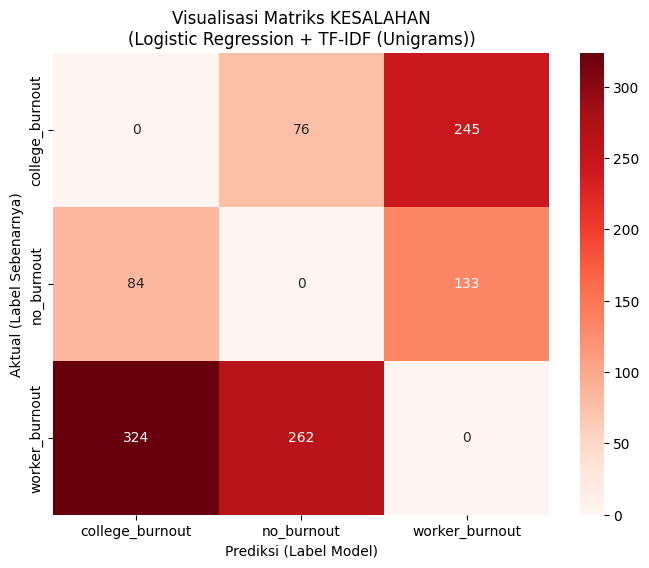


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3008           0               0
no_burnout                                 0        3113               0
worker_burnout                             0           0            2744


Visualisasi Matriks KEBENARAN:


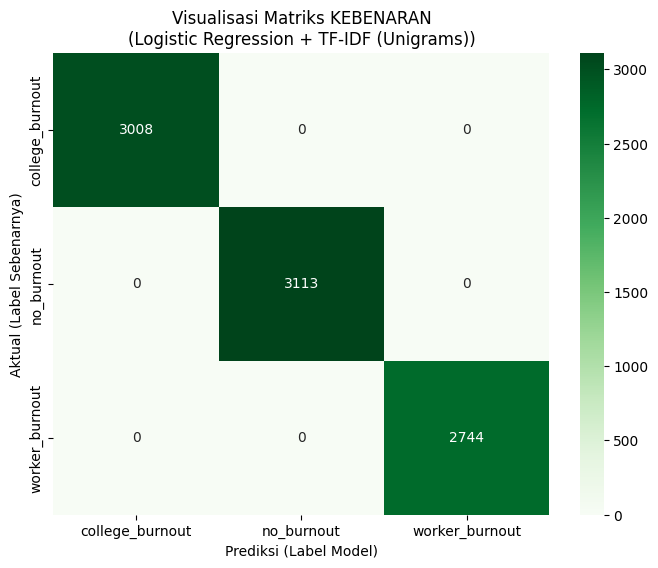


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
3                                                          feel fake like talent gift next person imposter waiting found cant cant make thing happen cant whatever   
7                                                                                                            feel bit crappy still saturday think stress something   
12                                                                                                                             tired feeling awkward around people   
29                                                                                                ive left run feeling agitated something time get back ive worked   
37                                                                                                                               feel really burdened pressed time   
70                                                                                                                              already feeling like le productive   
72                                                                                                                                            feel like bit boring   
75                                                                            feel thoroughly unwelcome school individual people clearly deeply moved work choices   
76                                                                                                                  wa day today fourth day still feeling horrible   
77                                                                                                                          appreciate reaching making feel valued   
78                                                                                                      feel numb desired college degree rewarding career marriage   
86                                                                                                                        gotta ewrt outline tennis work need time   
93                                                                                                                                feel determined great programmer   
98                                                                feel like opportunity everything gives opportunity suck everything convinced expected everything   
100                                                                                                            guys apparently fucking tired right feeling useless   
102  put much pressure meet target different area life feel something ha suffer something else successful despite trying maintain balance effort course consistent   
120                                                 may setbacks past optimism encourages pick dust learn experiences every failure lesson towards greater success   
127                                                                                                                             give much work still feeling blank   
136                                                                                   running low sleep feel lethargic useless carry anything cognitively involved   
152                                                                                                                            need feel like something worthwhile   
163                                                       want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
168                                                     spent hour pouring enthusiasm sensitivity effort tell story fullness see experience feel drained exhausted   
176                                                 desire success allconsuming driving individuals work long hours sacrifice personal relationships pursuit goals   
180                                                                                                             believe emotional component clue feel dissatisfied   
183     

In [30]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Logistic Regression"
NAMA_FITUR_ANALISIS = "TF-IDF (Unigrams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Logistic Regression + TF-IDF (N-grams)
Sedang melatih ulang Logistic Regression...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 842 (8.43%)
Jumlah kebenaran prediksi: 9147 (91.57%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0          41             221
no_burnout                                30           0              51
worker_burnout                           312         187               0


Visualisasi Matriks KESALAHAN:


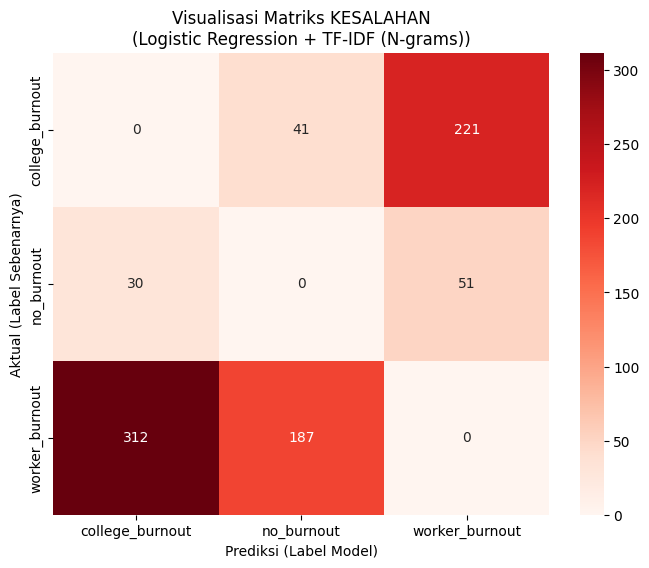


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3067           0               0
no_burnout                                 0        3249               0
worker_burnout                             0           0            2831


Visualisasi Matriks KEBENARAN:


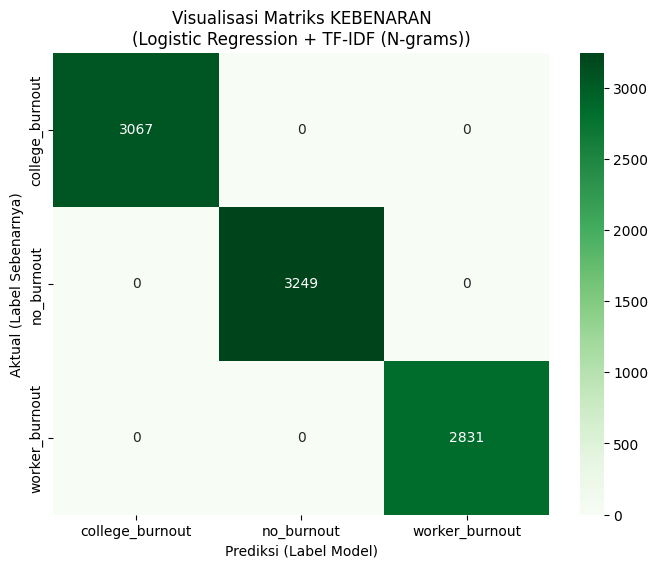


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
3                                                          feel fake like talent gift next person imposter waiting found cant cant make thing happen cant whatever   
7                                                                                                            feel bit crappy still saturday think stress something   
37                                                                                                                               feel really burdened pressed time   
41                                                                                                             know ive hit low point feeling weepy cleaning house   
70                                                                                                                              already feeling like le productive   
72                                                                                                                                            feel like bit boring   
76                                                                                                                  wa day today fourth day still feeling horrible   
77                                                                                                                          appreciate reaching making feel valued   
78                                                                                                      feel numb desired college degree rewarding career marriage   
86                                                                                                                        gotta ewrt outline tennis work need time   
93                                                                                                                                feel determined great programmer   
100                                                                                                            guys apparently fucking tired right feeling useless   
102  put much pressure meet target different area life feel something ha suffer something else successful despite trying maintain balance effort course consistent   
136                                                                                   running low sleep feel lethargic useless carry anything cognitively involved   
150        happy would like feel free experiment applying interviewing different occupations different fields order find really wanting retire need change careers   
163                                                       want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
169                                                                                                                        look back feel privileged made industry   
176                                                 desire success allconsuming driving individuals work long hours sacrifice personal relationships pursuit goals   
180                                                                                                             believe emotional component clue feel dissatisfied   
181                                                                                                                    feeling rather exhausted amp sleep deprived   
183                                                                                            burnt yet definitely feeling little singed around edge touch cranky   
188                                                                                                                                    feel really hopeful rd year   
203                                                                                                   feel remind people still exhausted actually still recovering   
223                                                                                                                                        bake feel less stressed   
231     

In [31]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Logistic Regression"
NAMA_FITUR_ANALISIS = "TF-IDF (N-grams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Logistic Regression + LDA Features
Sedang melatih ulang Logistic Regression...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 5680 (56.86%)
Jumlah kebenaran prediksi: 4309 (43.14%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0         676             882
no_burnout                              1181           0            1193
worker_burnout                           877         871               0


Visualisasi Matriks KESALAHAN:


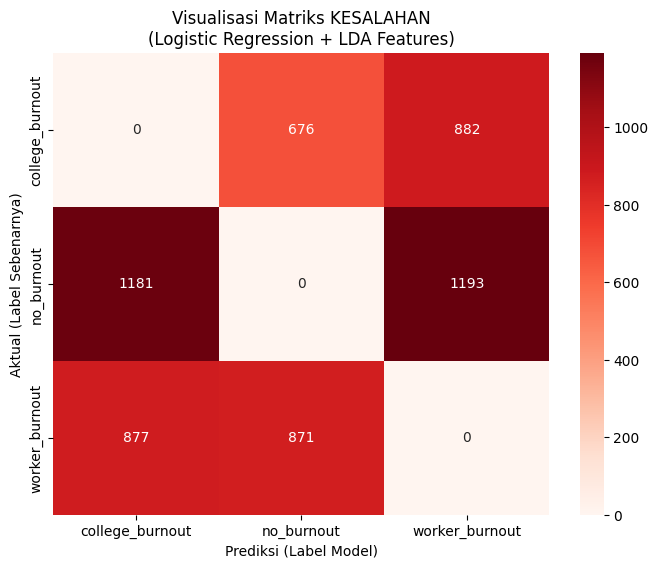


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         1771           0               0
no_burnout                                 0         956               0
worker_burnout                             0           0            1582


Visualisasi Matriks KEBENARAN:


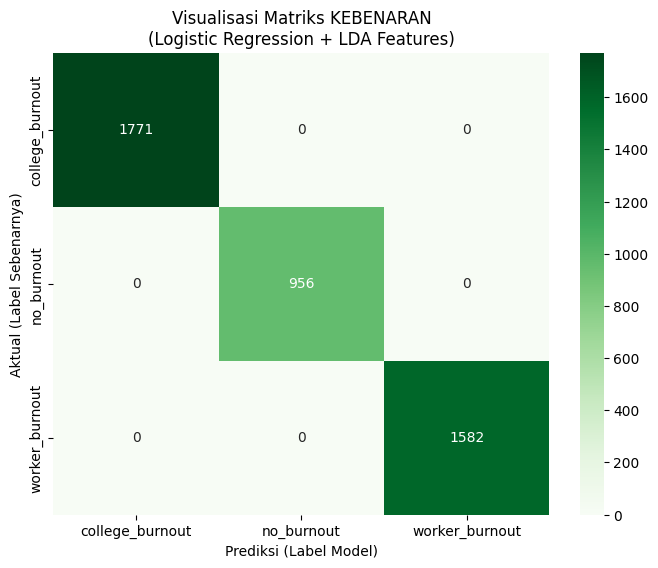


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
0                                                                                                                             feel doomed alone   
1                                                         used constantly working schoolwork weekend feel almost lost nothing specific get done   
5                                                                                                 mean feel really relaxed concentration jumped   
7                                                                                         feel bit crappy still saturday think stress something   
8                                                                                                                       feel intensely peaceful   
9                                                                                   wa starting feel defeated wa major attitude adjustment week   
15                                                                                                                      hour minutes class left   
16                                                                         dont see end sight annoy pressure feel productive balance everything   
19  try one last attempt fight feeling wa unpleasant unknown try trance self sleep picturing darkness shedding thought reason becoming one void   
21                                                                    really feel awful want lose audience blogging gives good confidence boost   
22                                                                                       going feel treat opportunity pursue creative endeavors   
24                                                                                                               feel successful happy progress   
26                                                                                        feel unloved mad put position expect different better   
28                                                                                                             feel deprived hungry like manage   
29                                                                             ive left run feeling agitated something time get back ive worked   
32                                                                                                    tired since moved months ago feel drained   
34                                                                                        feel unloved mad put position expect different better   
35                                                                                                     day made small thoughts surprises others   
40                                                                                                                 im already feeling exhausted   
42                                                         feeling find bit ungrateful competitive get london med schools gave first choice job   
45                                                                                                          suppose feeling pretty good settled   
47                                                                                                                      feel rather sympathetic   
48                                                               clearly see pattern feeling exhausted often connected cycle ovulation included   
51                                                                                              ive getting mood feel listless energy dont care   
53                                                               im hoping calm storm feel really peaceful relaxed even look ahead thing coming   

         label_asli   prediksi_model  
0        no_burnout  college_burnout  
1   college_burnout       no_burnout  
5        no_burnout   worker_burnout  
7    worker_burnout  college_burnout  
8        no_burnout  college_burnout  
9        no_burnout  college_burnout  
15  college_burnout       no_burnout  
16  

In [32]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Logistic Regression"
NAMA_FITUR_ANALISIS = "LDA Features"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

**Mendefinisikan Model (SVM)**

In [33]:
# ==========================================
# 12. Definisikan Model yang Akan Digunakan
# ==========================================
print("\n🧠 Mendefinisikan model klasifikasi...")
models = {
   "Linear SVM (SVC)": LinearSVC(random_state=42, max_iter=2000, dual=True)
}


🧠 Mendefinisikan model klasifikasi...


**Pelatihan dan Evaluasi (SVM)**



🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)


--- MENGGUNAKAN FITUR: Bag-of-Words (BoW) (Bentuk: (39955, 5023)) ---

  📊 Linear SVM (SVC) + Bag-of-Words (BoW)
  Sedang melatih Linear SVM (SVC)...
  Melakukan prediksi...

  Laporan Klasifikasi (Linear SVM (SVC) + Bag-of-Words (BoW)):
                 precision    recall  f1-score   support

college_burnout       0.90      0.93      0.92      3329
     no_burnout       0.92      0.97      0.95      3330
 worker_burnout       0.92      0.84      0.87      3330

       accuracy                           0.91      9989
      macro avg       0.91      0.91      0.91      9989
   weighted avg       0.91      0.91      0.91      9989

  Waktu eksekusi: 8.66 detik


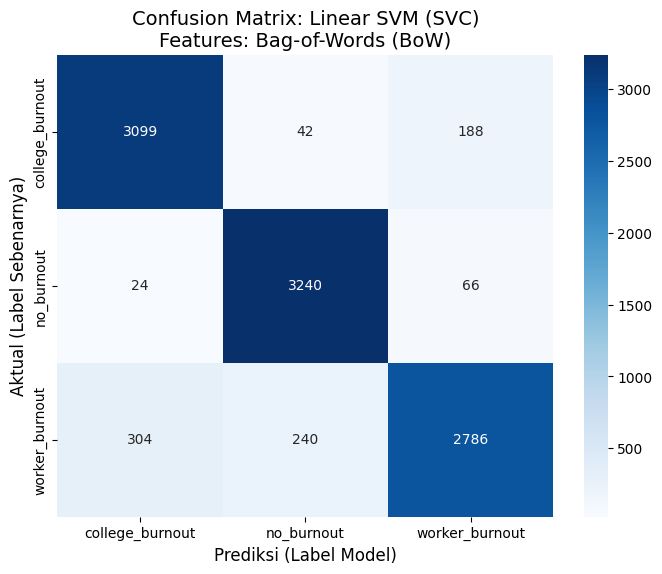



--- MENGGUNAKAN FITUR: TF-IDF (Unigrams) (Bentuk: (39955, 5023)) ---

  📊 Linear SVM (SVC) + TF-IDF (Unigrams)
  Sedang melatih Linear SVM (SVC)...
  Melakukan prediksi...

  Laporan Klasifikasi (Linear SVM (SVC) + TF-IDF (Unigrams)):
                 precision    recall  f1-score   support

college_burnout       0.90      0.92      0.91      3329
     no_burnout       0.91      0.96      0.94      3330
 worker_burnout       0.91      0.83      0.87      3330

       accuracy                           0.91      9989
      macro avg       0.91      0.91      0.90      9989
   weighted avg       0.91      0.91      0.90      9989

  Waktu eksekusi: 0.42 detik


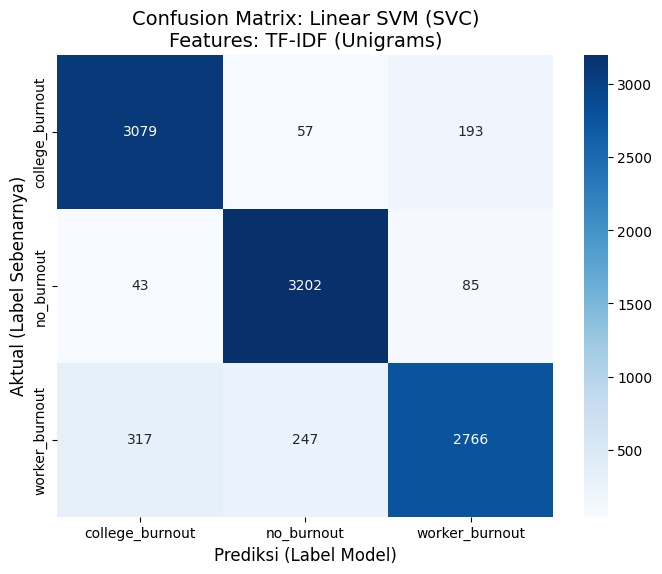



--- MENGGUNAKAN FITUR: TF-IDF (N-grams) (Bentuk: (39955, 15000)) ---

  📊 Linear SVM (SVC) + TF-IDF (N-grams)
  Sedang melatih Linear SVM (SVC)...
  Melakukan prediksi...

  Laporan Klasifikasi (Linear SVM (SVC) + TF-IDF (N-grams)):
                 precision    recall  f1-score   support

college_burnout       0.92      0.95      0.93      3329
     no_burnout       0.96      0.99      0.97      3330
 worker_burnout       0.95      0.88      0.91      3330

       accuracy                           0.94      9989
      macro avg       0.94      0.94      0.94      9989
   weighted avg       0.94      0.94      0.94      9989

  Waktu eksekusi: 0.51 detik


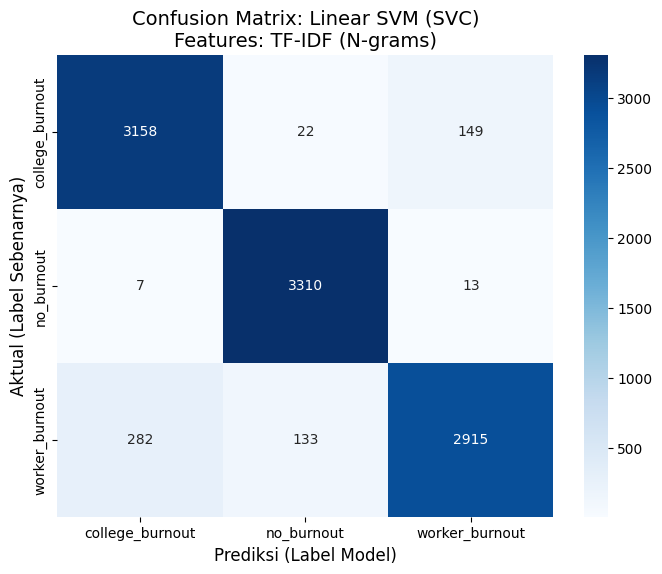



--- MENGGUNAKAN FITUR: LDA Features (Bentuk: (39955, 15)) ---

  📊 Linear SVM (SVC) + LDA Features
  Sedang melatih Linear SVM (SVC)...
  Melakukan prediksi...

  Laporan Klasifikasi (Linear SVM (SVC) + LDA Features):
                 precision    recall  f1-score   support

college_burnout       0.46      0.55      0.50      3329
     no_burnout       0.39      0.28      0.33      3330
 worker_burnout       0.43      0.48      0.46      3330

       accuracy                           0.44      9989
      macro avg       0.43      0.44      0.43      9989
   weighted avg       0.43      0.44      0.43      9989

  Waktu eksekusi: 0.79 detik


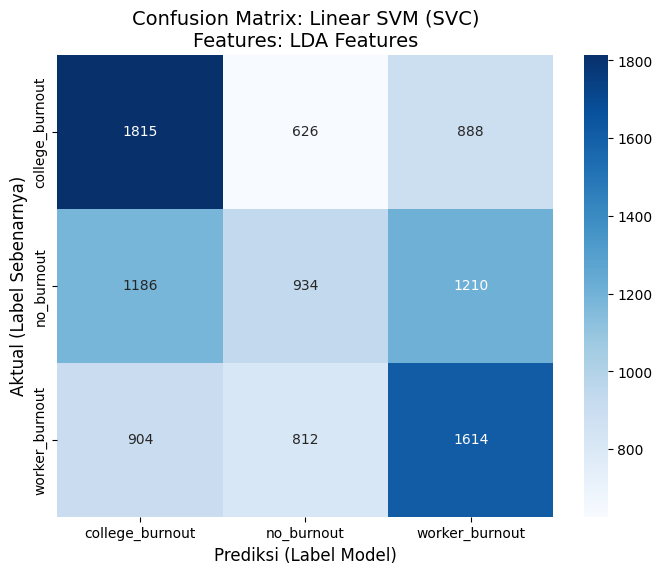

In [34]:
# ==========================================
# 14. Eksekusi Pelatihan & Evaluasi (Nested Loop)
# ==========================================
print("\n\n==============================================")
print("🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)")
print("==============================================")

# --- PENGATURAN VISUALISASI ---
# Setel ke False jika Anda tidak ingin 20 plot membanjiri notebook Anda
TAMPILKAN_CONFUSION_MATRIX = True

# Pastikan variabel y_train, y_test, le ada
try:
    # Loop untuk setiap metode feature extraction
    for method_name, (X_train_feat, X_test_feat) in feature_sets.items():
        print(f"\n\n--- MENGGUNAKAN FITUR: {method_name} (Bentuk: {X_train_feat.shape}) ---")

        # Loop untuk setiap model
        for model_name, model in models.items():

            print(f"\n  ==========================================")
            print(f"  📊 {model_name} + {method_name}")
            print(f"  ==========================================")

            start_time = time.time()

            # 1. Latih model
            print(f"  Sedang melatih {model_name}...")
            from sklearn.base import clone
            model_instance = clone(model)

            model_instance.fit(X_train_feat, y_train)

            # 2. Prediksi
            print(f"  Melakukan prediksi...")
            y_pred = model_instance.predict(X_test_feat)

            end_time = time.time()

            # 3. Tampilkan Laporan Klasifikasi
            print(f"\n  Laporan Klasifikasi ({model_name} + {method_name}):")
            report = classification_report(
                y_test,
                y_pred,
                target_names=le.classes_,  # Menggunakan LabelEncoder 'le'
                zero_division=0
            )
            print(report)
            print(f"  Waktu eksekusi: {end_time - start_time:.2f} detik")

            # ==========================================
            # 4. TAMBAHAN: Visualisasi Confusion Matrix
            # ==========================================
            if TAMPILKAN_CONFUSION_MATRIX:
                try:
                    cm = confusion_matrix(y_test, y_pred)
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                xticklabels=le.classes_,
                                yticklabels=le.classes_)
                    plt.title(f'Confusion Matrix: {model_name}\nFeatures: {method_name}', fontsize=14)
                    plt.ylabel('Aktual (Label Sebenarnya)', fontsize=12)
                    plt.xlabel('Prediksi (Label Model)', fontsize=12)
                    plt.show()
                except Exception as e:
                    print(f"  (Gagal membuat confusion matrix: {e})")

except NameError as e:
    print(f"\n❌ ERROR: Variabel tidak ditemukan: {e}")
    print("Pastikan Anda telah menjalankan sel kode sebelumnya yang mendefinisikan variabel 'le', 'y_train', 'y_test', dan semua 'X_train_*'.")
except Exception as e:
    print(f"\n❌ ERROR LAIN TERJADI: {e}")

**Error Analysis (SVM)**

🚀 Memulai Analisis Kesalahan untuk: Linear SVM (SVC) + Bag-of-Words (BoW)
Sedang melatih ulang Linear SVM (SVC)...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 864 (8.65%)
Jumlah kebenaran prediksi: 9125 (91.35%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0          42             188
no_burnout                                24           0              66
worker_burnout                           304         240               0


Visualisasi Matriks KESALAHAN:


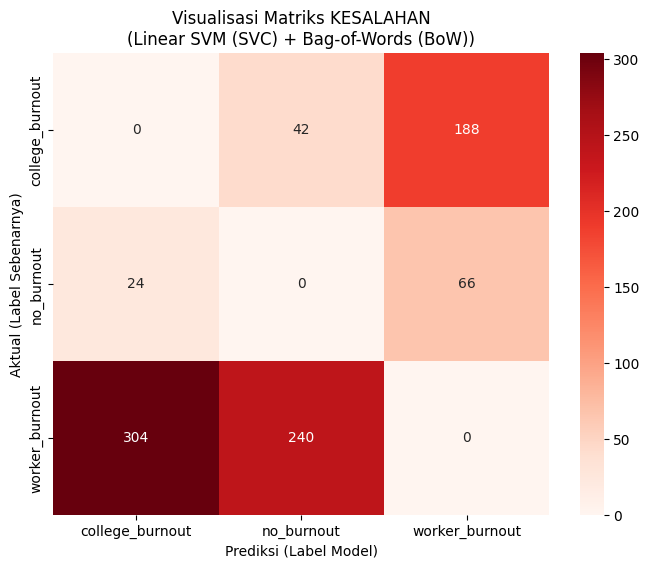


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3099           0               0
no_burnout                                 0        3240               0
worker_burnout                             0           0            2786


Visualisasi Matriks KEBENARAN:


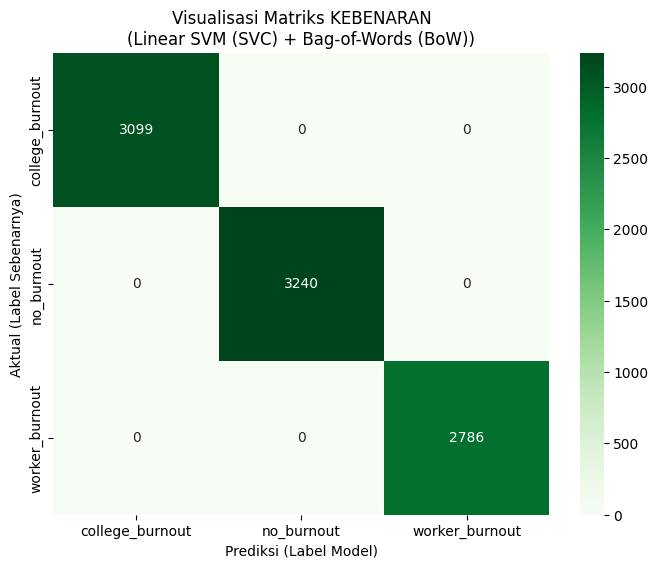


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
7                                                             feel bit crappy still saturday think stress something   
12                                                                              tired feeling awkward around people   
24                                                                                   feel successful happy progress   
37                                                                                feel really burdened pressed time   
65              feeling doomed taking panicked implications trying adjust idea also responsible massive undertaking   
70                                                                               already feeling like le productive   
76                                                                   wa day today fourth day still feeling horrible   
77                                                                           appreciate reaching making feel valued   
93                                                                                 feel determined great programmer   
100                                                             guys apparently fucking tired right feeling useless   
120  may setbacks past optimism encourages pick dust learn experiences every failure lesson towards greater success   
127                                                                              give much work still feeling blank   
133                                                 feel dirty complicit terrible working conditions lead disasters   
136                                    running low sleep feel lethargic useless carry anything cognitively involved   
163        want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
183                                             burnt yet definitely feeling little singed around edge touch cranky   
188                                                                                     feel really hopeful rd year   
203                                                    feel remind people still exhausted actually still recovering   
223                                                                                         bake feel less stressed   
231                                               wa overwhelmed feeling restlessness convinced worst human emotion   
232                                                                         running really late work feeling groggy   
239                                                                                        dont know feel irritated   
259                   arrived work time focus mind things feelings still making feel horribly lethargic unmotivated   
263                                 know lot related hormones making feel emotional apparently deal excess emotions   
276                                                                                        feel doomed fail respect   

          label_asli   prediksi_model  
7     worker_burnout  college_burnout  
12   college_burnout       no_burnout  
24        no_burnout   worker_burnout  
37    worker_burnout  college_burnout  
65   college_burnout   worker_burnout  
70   college_burnout   worker_burnout  
76    worker_burnout       no_burnout  
77        no_burnout   worker_burnout  
93    worker_burnout       no_burnout  
100  college_burnout   worker_burnout  
120   worker_burnout  college_burnout  
127  college_burnout   worker_burnout  
133   worker_burnout       no_burnout  
136   worker_burnout  college_burnout  
163   worker_burnout  college_burnout  
183  college_burnout   worker_burnout  
188   worker_burnout       no_burnout  
203   worker_burnout  college_burnout  
223   worker_burnout  college_burnout  
231   worker_burnout       no_burnout  
232   worker_burnout  college_burnout  
239       no_burnout   worker_burnout  
259   worker_burnout  college_burnout  
263   worker_burnout  college_burnout  
276   worker_bur

In [35]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Linear SVM (SVC)"
NAMA_FITUR_ANALISIS = "Bag-of-Words (BoW)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Linear SVM (SVC) + TF-IDF (Unigrams)
Sedang melatih ulang Linear SVM (SVC)...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 942 (9.43%)
Jumlah kebenaran prediksi: 9047 (90.57%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0          57             193
no_burnout                                43           0              85
worker_burnout                           317         247               0


Visualisasi Matriks KESALAHAN:


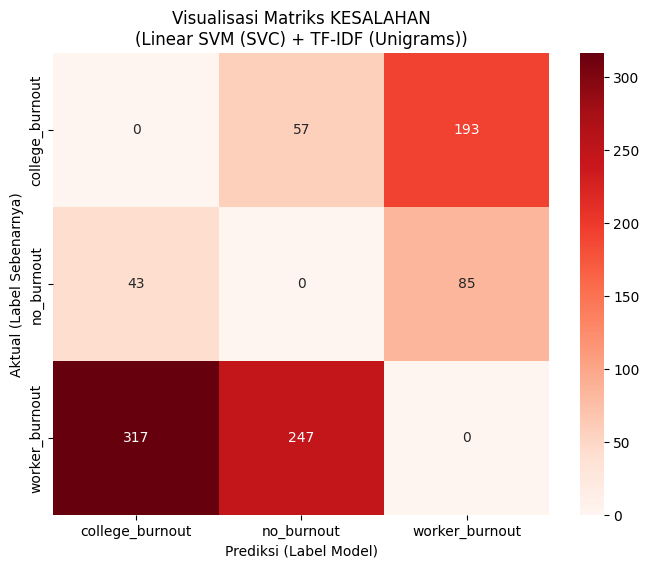


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3079           0               0
no_burnout                                 0        3202               0
worker_burnout                             0           0            2766


Visualisasi Matriks KEBENARAN:


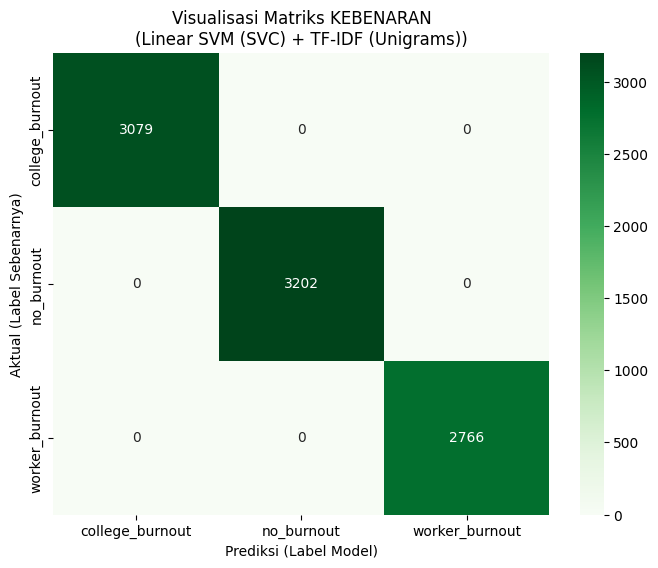


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
7                                                         feel bit crappy still saturday think stress something   
12                                                                          tired feeling awkward around people   
24                                                                               feel successful happy progress   
29                                             ive left run feeling agitated something time get back ive worked   
37                                                                            feel really burdened pressed time   
65          feeling doomed taking panicked implications trying adjust idea also responsible massive undertaking   
70                                                                           already feeling like le productive   
75                         feel thoroughly unwelcome school individual people clearly deeply moved work choices   
76                                                               wa day today fourth day still feeling horrible   
77                                                                       appreciate reaching making feel valued   
78                                                   feel numb desired college degree rewarding career marriage   
93                                                                             feel determined great programmer   
98             feel like opportunity everything gives opportunity suck everything convinced expected everything   
100                                                         guys apparently fucking tired right feeling useless   
127                                                                          give much work still feeling blank   
136                                running low sleep feel lethargic useless carry anything cognitively involved   
163    want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
168  spent hour pouring enthusiasm sensitivity effort tell story fullness see experience feel drained exhausted   
180                                                          believe emotional component clue feel dissatisfied   
183                                         burnt yet definitely feeling little singed around edge touch cranky   
188                                                                                 feel really hopeful rd year   
203                                                feel remind people still exhausted actually still recovering   
223                                                                                     bake feel less stressed   
231                                           wa overwhelmed feeling restlessness convinced worst human emotion   
232                                                                     running really late work feeling groggy   

          label_asli   prediksi_model  
7     worker_burnout  college_burnout  
12   college_burnout       no_burnout  
24        no_burnout   worker_burnout  
29        no_burnout   worker_burnout  
37    worker_burnout  college_burnout  
65   college_burnout   worker_burnout  
70   college_burnout   worker_burnout  
75    worker_burnout  college_burnout  
76    worker_burnout       no_burnout  
77        no_burnout   worker_burnout  
78    worker_burnout  college_burnout  
93    worker_burnout       no_burnout  
98        no_burnout   worker_burnout  
100  college_burnout   worker_burnout  
127  college_burnout   worker_burnout  
136   worker_burnout  college_burnout  
163   worker_burnout  college_burnout  
168  college_burnout   worker_burnout  
180  college_burnout   worker_burnout  
183  college_burnout   worker_burnout  
188   worker_burnout       no_burnout  
203   worker_burnout  college_burnout  
223   worker_burnout  college_burnout  
231   worker_burnout       no_burnout  
232   worker_burnout  college_burnout

In [36]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Linear SVM (SVC)"
NAMA_FITUR_ANALISIS = "TF-IDF (Unigrams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Linear SVM (SVC) + TF-IDF (N-grams)
Sedang melatih ulang Linear SVM (SVC)...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 606 (6.07%)
Jumlah kebenaran prediksi: 9383 (93.93%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0          22             149
no_burnout                                 7           0              13
worker_burnout                           282         133               0


Visualisasi Matriks KESALAHAN:


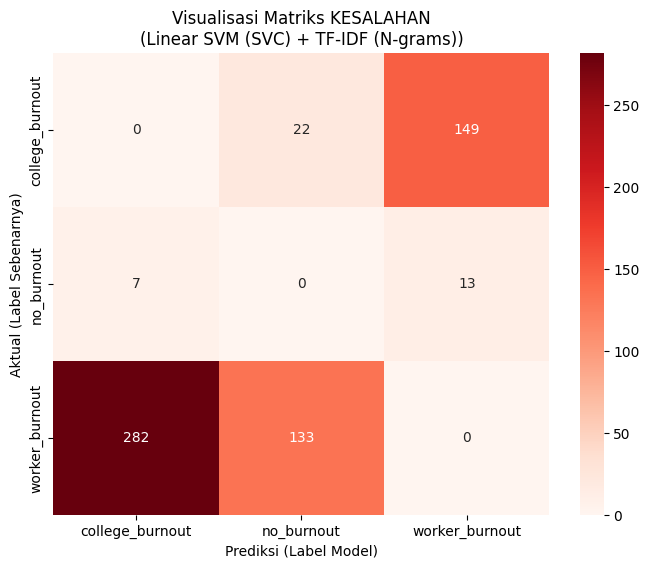


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3158           0               0
no_burnout                                 0        3310               0
worker_burnout                             0           0            2915


Visualisasi Matriks KEBENARAN:


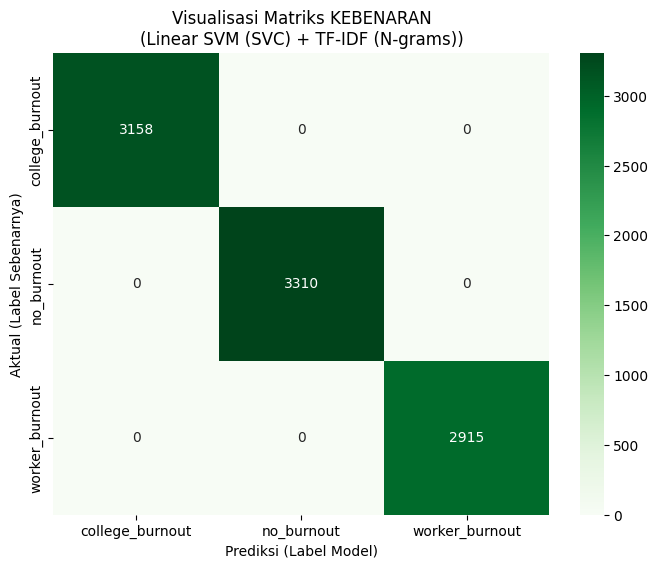


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
3                                                          feel fake like talent gift next person imposter waiting found cant cant make thing happen cant whatever   
4                                                                                                                                  im feeling stressed overwhelmed   
7                                                                                                            feel bit crappy still saturday think stress something   
54                                                                                                                             feeling pretty lethargic long drive   
76                                                                                                                  wa day today fourth day still feeling horrible   
78                                                                                                      feel numb desired college degree rewarding career marriage   
93                                                                                                                                feel determined great programmer   
102  put much pressure meet target different area life feel something ha suffer something else successful despite trying maintain balance effort course consistent   
136                                                                                   running low sleep feel lethargic useless carry anything cognitively involved   
150        happy would like feel free experiment applying interviewing different occupations different fields order find really wanting retire need change careers   
163                                                       want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
176                                                 desire success allconsuming driving individuals work long hours sacrifice personal relationships pursuit goals   
180                                                                                                             believe emotional component clue feel dissatisfied   
188                                                                                                                                    feel really hopeful rd year   
203                                                                                                   feel remind people still exhausted actually still recovering   
206                                                                                                      realized feel like victimized normal problem every one go   
223                                                                                                                                        bake feel less stressed   
231                                                                                              wa overwhelmed feeling restlessness convinced worst human emotion   
259                                                                  arrived work time focus mind things feelings still making feel horribly lethargic unmotivated   
273                                                                                       read feel frightfully annoyed getting point quickly enough leisure quick   
279                                                                                                                  ive feeling lethargic day excited work see mr   
320                                                                                      finish semester get degree get job feel respected get paid things company   
349                                                                                                     feel guilty leave end day guilt interrupts ability present   
378                                                                                                          still running low grade temp feeling really exhausted   
385     

In [37]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Linear SVM (SVC)"
NAMA_FITUR_ANALISIS = "TF-IDF (N-grams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Linear SVM (SVC) + LDA Features
Sedang melatih ulang Linear SVM (SVC)...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 5626 (56.32%)
Jumlah kebenaran prediksi: 4363 (43.68%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0         626             888
no_burnout                              1186           0            1210
worker_burnout                           904         812               0


Visualisasi Matriks KESALAHAN:


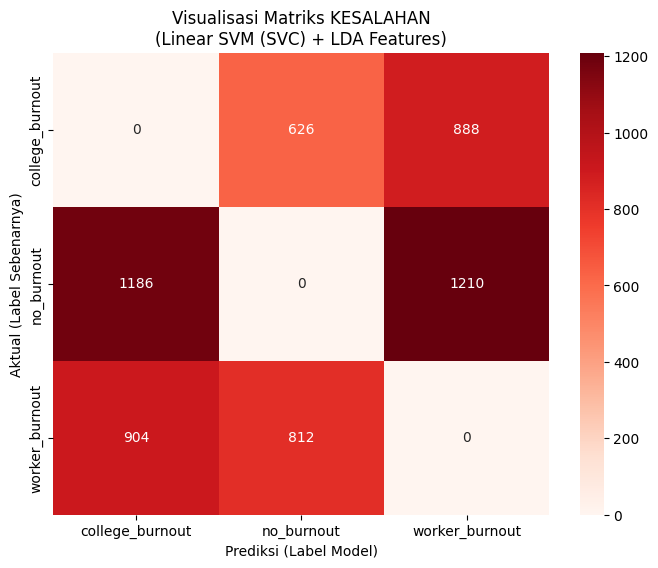


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         1815           0               0
no_burnout                                 0         934               0
worker_burnout                             0           0            1614


Visualisasi Matriks KEBENARAN:


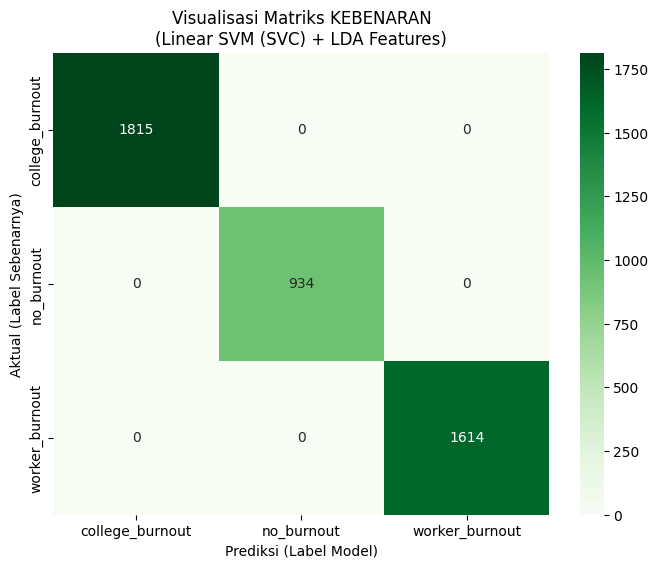


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
0                                                                                                                             feel doomed alone   
1                                                         used constantly working schoolwork weekend feel almost lost nothing specific get done   
5                                                                                                 mean feel really relaxed concentration jumped   
7                                                                                         feel bit crappy still saturday think stress something   
8                                                                                                                       feel intensely peaceful   
9                                                                                   wa starting feel defeated wa major attitude adjustment week   
15                                                                                                                      hour minutes class left   
16                                                                         dont see end sight annoy pressure feel productive balance everything   
19  try one last attempt fight feeling wa unpleasant unknown try trance self sleep picturing darkness shedding thought reason becoming one void   
21                                                                    really feel awful want lose audience blogging gives good confidence boost   
24                                                                                                               feel successful happy progress   
26                                                                                        feel unloved mad put position expect different better   
28                                                                                                             feel deprived hungry like manage   
29                                                                             ive left run feeling agitated something time get back ive worked   
32                                                                                                    tired since moved months ago feel drained   
34                                                                                        feel unloved mad put position expect different better   
35                                                                                                     day made small thoughts surprises others   
42                                                         feeling find bit ungrateful competitive get london med schools gave first choice job   
45                                                                                                          suppose feeling pretty good settled   
47                                                                                                                      feel rather sympathetic   
50                                                                                                                    feeling unimportant world   
51                                                                                              ive getting mood feel listless energy dont care   
53                                                               im hoping calm storm feel really peaceful relaxed even look ahead thing coming   
56                                                dislike heartbreak feeling everyone starts ask happen cannot control emotions literally broke   
57                                                            theres nothing quite like desire find true inner peace contentment within oneself   

         label_asli   prediksi_model  
0        no_burnout  college_burnout  
1   college_burnout       no_burnout  
5        no_burnout   worker_burnout  
7    worker_burnout  college_burnout  
8        no_burnout  college_burnout  
9        no_burnout  college_burnout  
15  college_burnout       no_burnout  
16  

In [38]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Linear SVM (SVC)"
NAMA_FITUR_ANALISIS = "LDA Features"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

**Mendefinisikan Model (Random Forest)**

In [39]:
# ==========================================
# 12. Definisikan Model yang Akan Digunakan
# ==========================================
print("\n🧠 Mendefinisikan model klasifikasi...")
models = {
   "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)
}


🧠 Mendefinisikan model klasifikasi...


**Pelatihan dan Evaluasi (Random Forest)**



🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)


--- MENGGUNAKAN FITUR: Bag-of-Words (BoW) (Bentuk: (39955, 5023)) ---

  📊 Random Forest + Bag-of-Words (BoW)
  Sedang melatih Random Forest...
  Melakukan prediksi...

  Laporan Klasifikasi (Random Forest + Bag-of-Words (BoW)):
                 precision    recall  f1-score   support

college_burnout       0.94      0.98      0.96      3329
     no_burnout       0.95      1.00      0.98      3330
 worker_burnout       0.99      0.89      0.93      3330

       accuracy                           0.96      9989
      macro avg       0.96      0.96      0.96      9989
   weighted avg       0.96      0.96      0.96      9989

  Waktu eksekusi: 45.02 detik


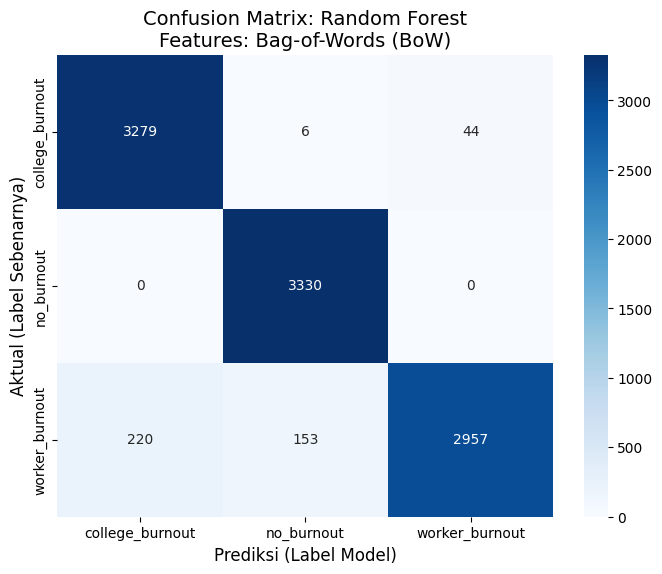



--- MENGGUNAKAN FITUR: TF-IDF (Unigrams) (Bentuk: (39955, 5023)) ---

  📊 Random Forest + TF-IDF (Unigrams)
  Sedang melatih Random Forest...
  Melakukan prediksi...

  Laporan Klasifikasi (Random Forest + TF-IDF (Unigrams)):
                 precision    recall  f1-score   support

college_burnout       0.93      0.98      0.96      3329
     no_burnout       0.96      1.00      0.98      3330
 worker_burnout       0.98      0.89      0.93      3330

       accuracy                           0.96      9989
      macro avg       0.96      0.96      0.96      9989
   weighted avg       0.96      0.96      0.96      9989

  Waktu eksekusi: 39.76 detik


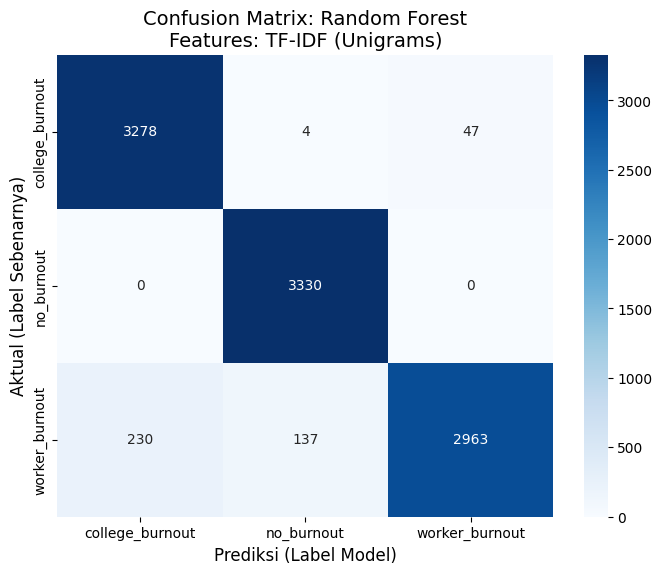



--- MENGGUNAKAN FITUR: TF-IDF (N-grams) (Bentuk: (39955, 15000)) ---

  📊 Random Forest + TF-IDF (N-grams)
  Sedang melatih Random Forest...
  Melakukan prediksi...

  Laporan Klasifikasi (Random Forest + TF-IDF (N-grams)):
                 precision    recall  f1-score   support

college_burnout       0.94      0.98      0.96      3329
     no_burnout       0.97      1.00      0.99      3330
 worker_burnout       0.98      0.91      0.94      3330

       accuracy                           0.96      9989
      macro avg       0.96      0.96      0.96      9989
   weighted avg       0.96      0.96      0.96      9989

  Waktu eksekusi: 75.78 detik


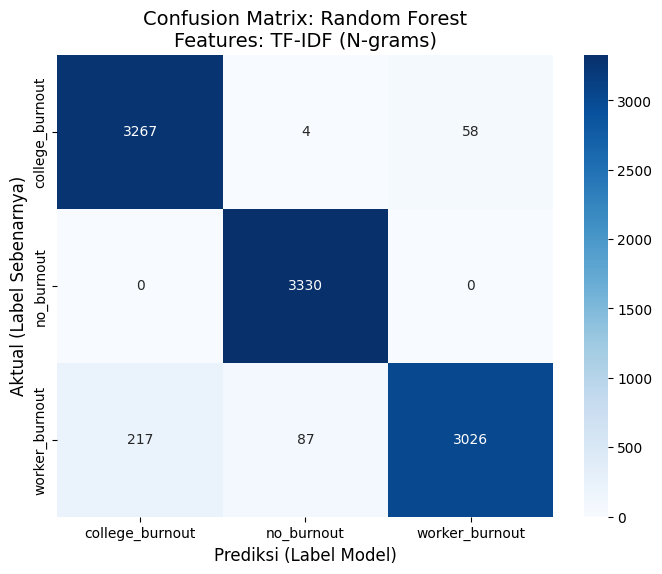



--- MENGGUNAKAN FITUR: LDA Features (Bentuk: (39955, 15)) ---

  📊 Random Forest + LDA Features
  Sedang melatih Random Forest...
  Melakukan prediksi...

  Laporan Klasifikasi (Random Forest + LDA Features):
                 precision    recall  f1-score   support

college_burnout       0.89      0.96      0.93      3329
     no_burnout       0.97      1.00      0.98      3330
 worker_burnout       0.96      0.86      0.91      3330

       accuracy                           0.94      9989
      macro avg       0.94      0.94      0.94      9989
   weighted avg       0.94      0.94      0.94      9989

  Waktu eksekusi: 10.30 detik


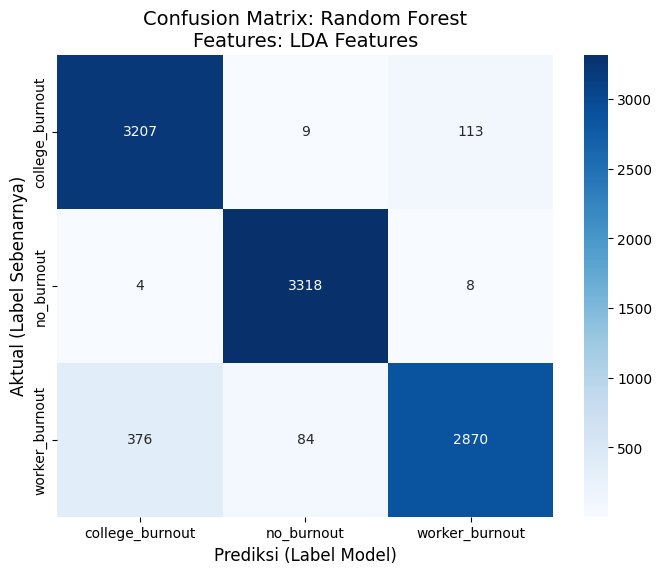

In [40]:
# ==========================================
# 14. Eksekusi Pelatihan & Evaluasi (Nested Loop)
# ==========================================
print("\n\n==============================================")
print("🚀 MEMULAI EKSEKUSI PELATIHAN & EVALUASI (20 KOMBINASI)")
print("==============================================")

# --- PENGATURAN VISUALISASI ---
# Setel ke False jika Anda tidak ingin 20 plot membanjiri notebook Anda
TAMPILKAN_CONFUSION_MATRIX = True

# Pastikan variabel y_train, y_test, le ada
try:
    # Loop untuk setiap metode feature extraction
    for method_name, (X_train_feat, X_test_feat) in feature_sets.items():
        print(f"\n\n--- MENGGUNAKAN FITUR: {method_name} (Bentuk: {X_train_feat.shape}) ---")

        # Loop untuk setiap model
        for model_name, model in models.items():

            print(f"\n  ==========================================")
            print(f"  📊 {model_name} + {method_name}")
            print(f"  ==========================================")

            start_time = time.time()

            # 1. Latih model
            print(f"  Sedang melatih {model_name}...")
            from sklearn.base import clone
            model_instance = clone(model)

            model_instance.fit(X_train_feat, y_train)

            # 2. Prediksi
            print(f"  Melakukan prediksi...")
            y_pred = model_instance.predict(X_test_feat)

            end_time = time.time()

            # 3. Tampilkan Laporan Klasifikasi
            print(f"\n  Laporan Klasifikasi ({model_name} + {method_name}):")
            report = classification_report(
                y_test,
                y_pred,
                target_names=le.classes_,  # Menggunakan LabelEncoder 'le'
                zero_division=0
            )
            print(report)
            print(f"  Waktu eksekusi: {end_time - start_time:.2f} detik")

            # ==========================================
            # 4. TAMBAHAN: Visualisasi Confusion Matrix
            # ==========================================
            if TAMPILKAN_CONFUSION_MATRIX:
                try:
                    cm = confusion_matrix(y_test, y_pred)
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                xticklabels=le.classes_,
                                yticklabels=le.classes_)
                    plt.title(f'Confusion Matrix: {model_name}\nFeatures: {method_name}', fontsize=14)
                    plt.ylabel('Aktual (Label Sebenarnya)', fontsize=12)
                    plt.xlabel('Prediksi (Label Model)', fontsize=12)
                    plt.show()
                except Exception as e:
                    print(f"  (Gagal membuat confusion matrix: {e})")

except NameError as e:
    print(f"\n❌ ERROR: Variabel tidak ditemukan: {e}")
    print("Pastikan Anda telah menjalankan sel kode sebelumnya yang mendefinisikan variabel 'le', 'y_train', 'y_test', dan semua 'X_train_*'.")
except Exception as e:
    print(f"\n❌ ERROR LAIN TERJADI: {e}")

**Error Analysis (Random Forest)**

🚀 Memulai Analisis Kesalahan untuk: Random Forest + Bag-of-Words (BoW)
Sedang melatih ulang Random Forest...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 423 (4.23%)
Jumlah kebenaran prediksi: 9566 (95.77%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0           6              44
worker_burnout                           220         153               0


Visualisasi Matriks KESALAHAN:


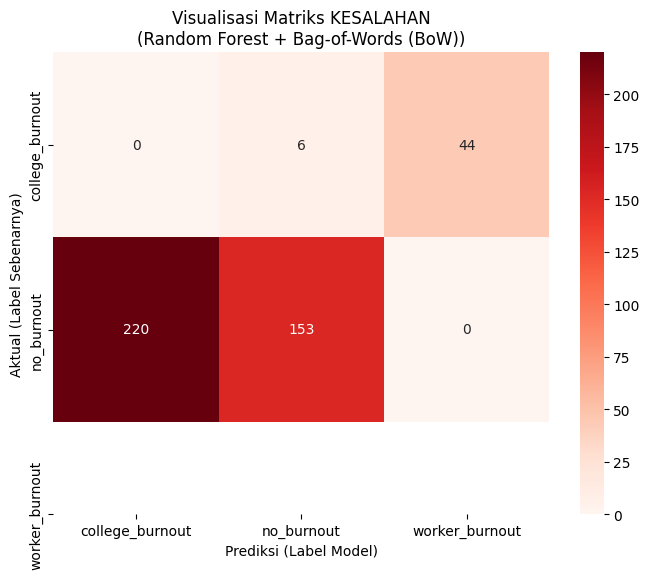


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3279           0               0
no_burnout                                 0        3330               0
worker_burnout                             0           0            2957


Visualisasi Matriks KEBENARAN:


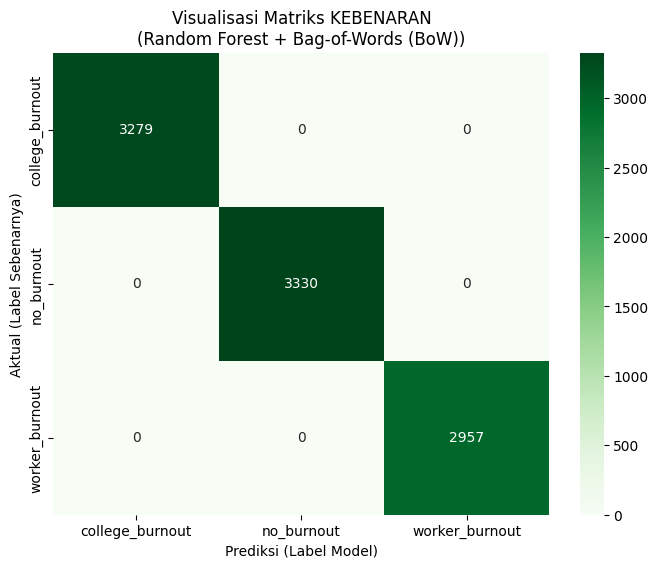


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
7                                               feel bit crappy still saturday think stress something   
22                                             going feel treat opportunity pursue creative endeavors   
41                                                know ive hit low point feeling weepy cleaning house   
75               feel thoroughly unwelcome school individual people clearly deeply moved work choices   
76                                                     wa day today fourth day still feeling horrible   
93                                                                   feel determined great programmer   
136                      running low sleep feel lethargic useless carry anything cognitively involved   
203                                      feel remind people still exhausted actually still recovering   
223                                                                           bake feel less stressed   
231                                 wa overwhelmed feeling restlessness convinced worst human emotion   
276                                                                          feel doomed fail respect   
277                                posted dealing workplace mega bitch feeling anger hurt incredulous   
357       feel discouraged sometimes engaging challenging activities related computer science theatre   
371                          often feel though im student teacher know im reason perspective valuable   
385             several reason think going uca going leave feeling bitter unhappy overall unfulfilled   
394                                                                              feeling appreciative   
405                                                                         feel honoured overwhelmed   
413                      desperately needed spring break people work school setting know feeling well   
471               work butt school coaching yet still feel though grade inadequate never enough money   
482  wa percent sure wa going retire last month feeling ok contributing kinda changed mind ching said   
489                                     worked writing papers day without feeling least bit depressed   
498                                                                                 feel stress broke   
508                                                      want crumble stress joy feel like lost sucky   
522                        feeling guilty able work book every day jobs relationships get way ya know   
539                       feeling less stressed today still experiencing effects overstressed stomach   

          label_asli   prediksi_model  
7     worker_burnout  college_burnout  
22    worker_burnout       no_burnout  
41    worker_burnout       no_burnout  
75    worker_burnout  college_burnout  
76    worker_burnout       no_burnout  
93    worker_burnout       no_burnout  
136   worker_burnout  college_burnout  
203   worker_burnout  college_burnout  
223   worker_burnout  college_burnout  
231   worker_burnout  college_burnout  
276   worker_burnout       no_burnout  
277   worker_burnout       no_burnout  
357   worker_burnout  college_burnout  
371   worker_burnout  college_burnout  
385  college_burnout   worker_burnout  
394   worker_burnout       no_burnout  
405   worker_burnout  college_burnout  
413   worker_burnout  college_burnout  
471   worker_burnout  college_burnout  
482   worker_burnout       no_burnout  
489   worker_burnout  college_burnout  
498   worker_burnout  college_burnout  
508   worker_burnout  college_burnout  
522   worker_burnout  college_burnout  
539   worker_burnout  college_burnout

In [41]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Random Forest"
NAMA_FITUR_ANALISIS = "Bag-of-Words (BoW)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Random Forest + TF-IDF (Unigrams)
Sedang melatih ulang Random Forest...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 418 (4.18%)
Jumlah kebenaran prediksi: 9571 (95.82%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0           4              47
worker_burnout                           230         137               0


Visualisasi Matriks KESALAHAN:


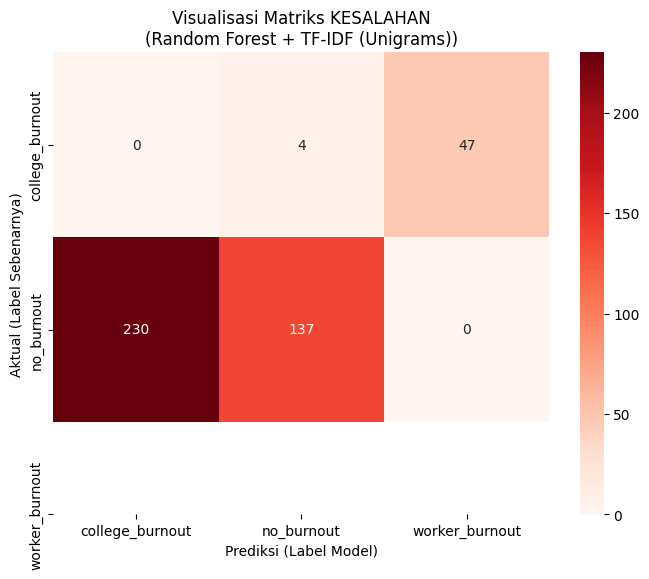


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3278           0               0
no_burnout                                 0        3330               0
worker_burnout                             0           0            2963


Visualisasi Matriks KEBENARAN:


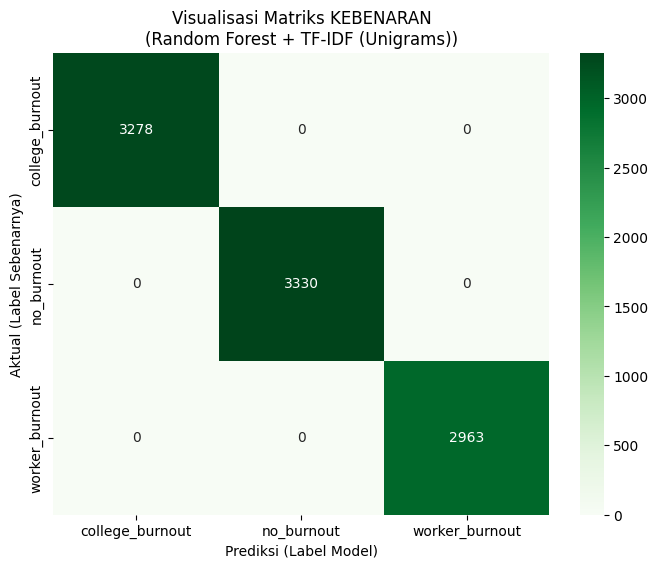


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
75                                                                      feel thoroughly unwelcome school individual people clearly deeply moved work choices   
93                                                                                                                          feel determined great programmer   
120                                           may setbacks past optimism encourages pick dust learn experiences every failure lesson towards greater success   
136                                                                             running low sleep feel lethargic useless carry anything cognitively involved   
150  happy would like feel free experiment applying interviewing different occupations different fields order find really wanting retire need change careers   
188                                                                                                                              feel really hopeful rd year   
203                                                                                             feel remind people still exhausted actually still recovering   
223                                                                                                                                  bake feel less stressed   
231                                                                                        wa overwhelmed feeling restlessness convinced worst human emotion   
277                                                                                       posted dealing workplace mega bitch feeling anger hurt incredulous   
357                                                              feel discouraged sometimes engaging challenging activities related computer science theatre   
371                                                                                 often feel though im student teacher know im reason perspective valuable   
385                                                                    several reason think going uca going leave feeling bitter unhappy overall unfulfilled   
394                                                                                                                                     feeling appreciative   
405                                                                                                                                feel honoured overwhelmed   
413                                                                             desperately needed spring break people work school setting know feeling well   
432                                                                                                                       feel somehow punished seems unfair   
471                                                                      work butt school coaching yet still feel though grade inadequate never enough money   
482                                                         wa percent sure wa going retire last month feeling ok contributing kinda changed mind ching said   
489                                                                                            worked writing papers day without feeling least bit depressed   
498                                                                                                                                        feel stress broke   
508                                                                                                             want crumble stress joy feel like lost sucky   
522                                                                               feeling guilty able work book every day jobs relationships get way ya know   
558                                                                 im fucking pathetic yet adamantly strengthened day wonderful scalding feeling discontent   
566                                                                                                                       feeling overly inhibited uncer

In [42]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Random Forest"
NAMA_FITUR_ANALISIS = "TF-IDF (Unigrams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Random Forest + TF-IDF (N-grams)
Sedang melatih ulang Random Forest...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 366 (3.66%)
Jumlah kebenaran prediksi: 9623 (96.34%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0           4              58
worker_burnout                           217          87               0


Visualisasi Matriks KESALAHAN:


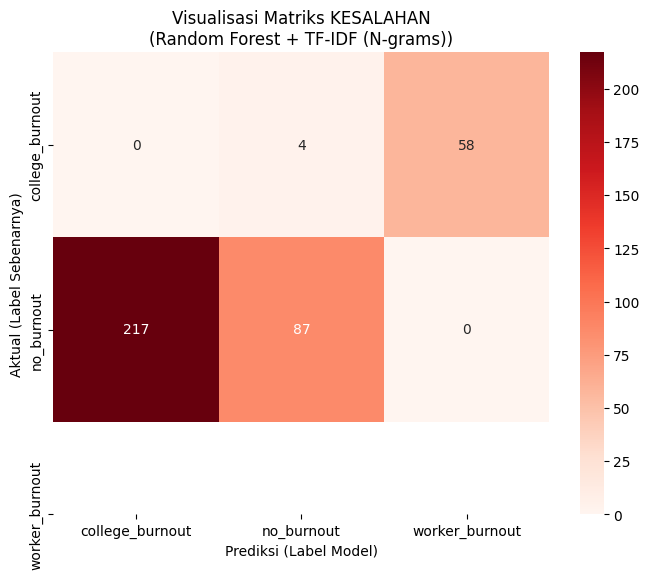


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3267           0               0
no_burnout                                 0        3330               0
worker_burnout                             0           0            3026


Visualisasi Matriks KEBENARAN:


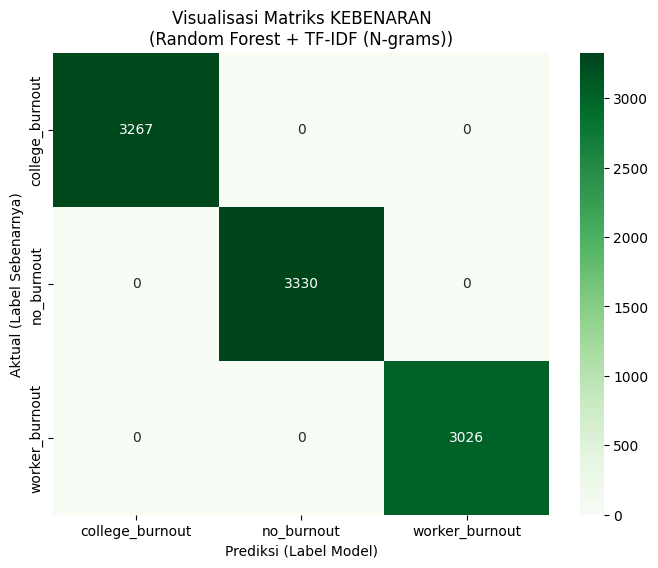


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
67                                                                                                                              feeling wa stubborn actually learn time table properly   
93                                                                                                                                                    feel determined great programmer   
136                                                                                                       running low sleep feel lethargic useless carry anything cognitively involved   
203                                                                                                                       feel remind people still exhausted actually still recovering   
231                                                                                                                  wa overwhelmed feeling restlessness convinced worst human emotion   
276                                                                                                                                                           feel doomed fail respect   
277                                                                                                                 posted dealing workplace mega bitch feeling anger hurt incredulous   
340                                                                                                                               admit feeling little cranky doubting writing ability   
357                                                                                        feel discouraged sometimes engaging challenging activities related computer science theatre   
371                                                                                                           often feel though im student teacher know im reason perspective valuable   
385                                                                                              several reason think going uca going leave feeling bitter unhappy overall unfulfilled   
394                                                                                                                                                               feeling appreciative   
405                                                                                                                                                          feel honoured overwhelmed   
432                                                                                                                                                 feel somehow punished seems unfair   
489                                                                                                                      worked writing papers day without feeling least bit depressed   
498                                                                                                                                                                  feel stress broke   
539                                                                                                        feeling less stressed today still experiencing effects overstressed stomach   
583                                    im going deny feel like ive missed opportunity ive made mistake guess part learning curve someday itll make sense regardless whether get answer   
602                                                                                                      feel suffering serious doubt artistic ability worry many technical inadequacy   
607  used much equate worth accomplished ended happening wa would get totally overwhelmed would start avoid everything hence getting nothing done feeling really shitty whole endeavor   
619                                                                                                                                      feel drained days start every day tired night   
631                                                                                   

In [43]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Random Forest"
NAMA_FITUR_ANALISIS = "TF-IDF (N-grams)"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

🚀 Memulai Analisis Kesalahan untuk: Random Forest + LDA Features
Sedang melatih ulang Random Forest...
Membuat prediksi pada data test...

✅ Analisis Selesai.
Jumlah kesalahan prediksi: 594 (5.95%)
Jumlah kebenaran prediksi: 9395 (94.05%)
Total data test: 9989

Distribusi kesalahan prediksi (Matriks Kesalahan):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                            0           9             113
no_burnout                                 4           0               8
worker_burnout                           376          84               0


Visualisasi Matriks KESALAHAN:


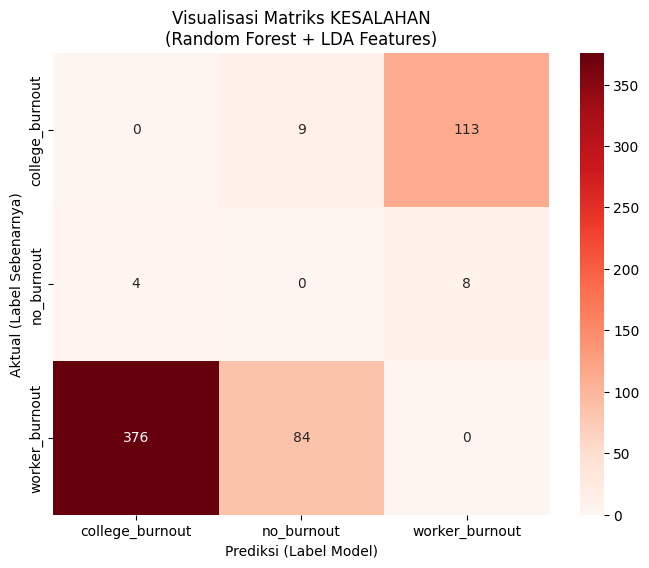


Distribusi kebenaran prediksi (Matriks Kebenaran):


Prediksi Model (pred_label)  college_burnout  no_burnout  worker_burnout
Label Asli (true_label)                                                 
college_burnout                         3207           0               0
no_burnout                                 0        3318               0
worker_burnout                             0           0            2870


Visualisasi Matriks KEBENARAN:


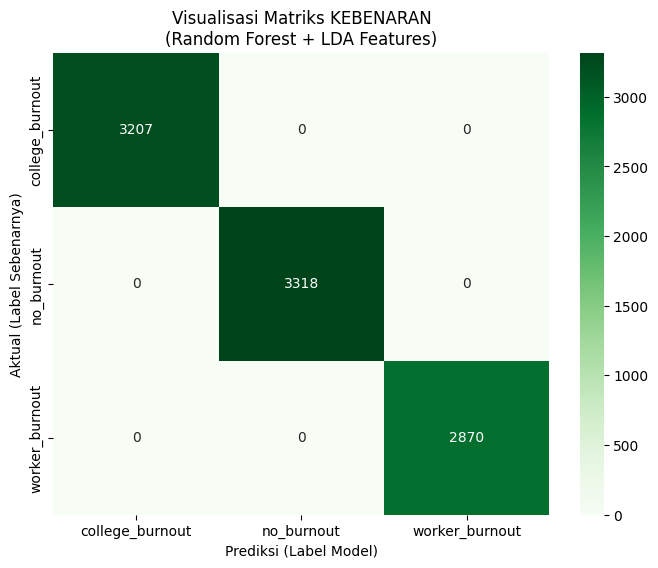


Contoh Teks yang Salah Prediksi (25 pertama):


text  \
7                                                       feel bit crappy still saturday think stress something   
60                                                                                 im tired feeling worthless   
67                                                     feeling wa stubborn actually learn time table properly   
134                                                 working started working gym first found feeling energetic   
136                              running low sleep feel lethargic useless carry anything cognitively involved   
137                                                            started working boss feel happy enjoy life way   
146                                             attitude worker appears grateful work poutingface poutingface   
163  want go home sleep three day wake nothing often next day schedule packed thinking id make feel exhausted   
184                                                                                   feeling lil overwhelmed   
203                                              feel remind people still exhausted actually still recovering   
206                                                 realized feel like victimized normal problem every one go   
223                                                                                   bake feel less stressed   
224                                                   feel saddened heartbroken almost betrayed work time put   
285                                                         suddenly feeling bit homesick study keep occupied   
340                                                      admit feeling little cranky doubting writing ability   
357               feel discouraged sometimes engaging challenging activities related computer science theatre   
378                                                     still running low grade temp feeling really exhausted   
379                                                                                   feel become unimportant   
385                     several reason think going uca going leave feeling bitter unhappy overall unfulfilled   
391                                                                     power run k without feeling exhausted   
394                                                                                      feeling appreciative   
397                                         finish fucking coursework gave headache angersymbol nauseatedface   
399                                                             feel like cannot concentrate think gets messy   
440                                         feel working vain like last week woman phone told problem english   
451                                                                dislike feeling like failure resigned make   

          label_asli   prediksi_model  
7     worker_burnout  college_burnout  
60    worker_burnout       no_burnout  
67   college_burnout   worker_burnout  
134   worker_burnout  college_burnout  
136   worker_burnout  college_burnout  
137   worker_burnout  college_burnout  
146   worker_burnout  college_burnout  
163   worker_burnout  college_burnout  
184  college_burnout   worker_burnout  
203   worker_burnout  college_burnout  
206   worker_burnout  college_burnout  
223   worker_burnout  college_burnout  
224   worker_burnout  college_burnout  
285  college_burnout   worker_burnout  
340   worker_burnout  college_burnout  
357   worker_burnout  college_burnout  
378   worker_burnout  college_burnout  
379       no_burnout   worker_burnout  
385  college_burnout   worker_burnout  
391   worker_burnout  college_burnout  
394   worker_burnout       no_burnout  
397  college_burnout   worker_burnout  
399  college_burnout   worker_burnout  
440   worker_burnout  college_burnout  
451   worker_burnout  college_burnout

In [44]:
# ==========================================
# 15. KODE ANALISIS KESALAHAN (v4 - Dengan Visualisasi)
# ==========================================

import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # (Meskipun crosstab bisa, ini best practice)

# --- 1. PILIH MODEL DAN FITUR ---
# Ubah string di bawah ini sesuai dengan model & fitur yang ingin Anda analisis
NAMA_MODEL_ANALISIS = "Random Forest"
NAMA_FITUR_ANALISIS = "LDA Features"
# -----------------------------------

print(f"🚀 Memulai Analisis Kesalahan untuk: {NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS}")

# 2. Ambil Model dan Fitur
try:
    model_to_analyze = models[NAMA_MODEL_ANALISIS]
    X_train_feat, X_test_feat = feature_sets[NAMA_FITUR_ANALISIS]
    model_instance = clone(model_to_analyze)

except KeyError as e:
    print(f"❌ ERROR: Nama tidak ditemukan: {e}. Pastikan nama model/fitur sudah benar.")
    raise e
except NameError as e:
    print(f"❌ ERROR: Pastikan dictionary 'models' and 'feature_sets' ada. {e}")
    raise e

# 3. Latih Ulang Model yang Dipilih
print(f"Sedang melatih ulang {NAMA_MODEL_ANALISIS}...")
# y_train adalah array label angka
model_instance.fit(X_train_feat, y_train)

# 4. Buat Prediksi
print("Membuat prediksi pada data test...")
y_pred_analysis = model_instance.predict(X_test_feat)

# 5. Buat DataFrame Analisis
try:
    analysis_df = pd.DataFrame({
        'text': X_test,
        'label_encoded': y_test,
        'prediction_encoded': y_pred_analysis
    })

except NameError as e:
    print(f"❌ ERROR: Variabel 'X_test' or 'y_test' tidak ditemukan. {e}")
    raise e

# 6. Filter Kesalahan dan Kebenaran
errors_df = analysis_df[analysis_df['label_encoded'] != analysis_df['prediction_encoded']]
correct_df = analysis_df[analysis_df['label_encoded'] == analysis_df['prediction_encoded']] # <-- BARU

# 7. Jalankan Analisis, Termasuk Rangkuman & Matriks Kesalahan
try:
    # --- TAMBAHAN 1: Hitung Total Kesalahan & Persentase ---
    jumlah_kesalahan = len(errors_df)
    jumlah_kebenaran = len(correct_df) # <-- BARU
    jumlah_total_test = len(y_test)
    persentase_kesalahan = (jumlah_kesalahan / jumlah_total_test) * 100
    persentase_kebenaran = (jumlah_kebenaran / jumlah_total_test) * 100 # <-- BARU

    print(f"\n✅ Analisis Selesai.")
    print(f"Jumlah kesalahan prediksi: {jumlah_kesalahan} ({persentase_kesalahan:.2f}%)")
    print(f"Jumlah kebenaran prediksi: {jumlah_kebenaran} ({persentase_kebenaran:.2f}%)")
    print(f"Total data test: {jumlah_total_test}")

    # --- Ubah angka menjadi teks label (untuk KEDUA dataframe) ---
    errors_df = errors_df.copy()
    correct_df = correct_df.copy() # <-- BARU

    errors_df['label_asli'] = le.inverse_transform(errors_df['label_encoded'])
    errors_df['prediksi_model'] = le.inverse_transform(errors_df['prediction_encoded'])

    correct_df['label_asli'] = le.inverse_transform(correct_df['label_encoded']) # <-- BARU
    correct_df['prediksi_model'] = le.inverse_transform(correct_df['prediction_encoded']) # <-- BARU

    # --- TAMBAHAN 2: Tampilkan Distribusi Kesalahan (Sesuai Permintaan) ---
    print("\nDistribusi kesalahan prediksi (Matriks Kesalahan):")
    error_distribution = pd.crosstab(
        errors_df['label_asli'],
        errors_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(error_distribution)

    # --- TAMBAHAN 3: Visualisasi Matriks Kesalahan ---
    print("\nVisualisasi Matriks KESALAHAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_distribution, annot=True, fmt='d', cmap='Reds',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KESALAHAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- TAMBAHAN 4: Tampilkan Distribusi Kebenaran (BARU) ---
    print("\nDistribusi kebenaran prediksi (Matriks Kebenaran):")
    correct_distribution = pd.crosstab(
        correct_df['label_asli'],
        correct_df['prediksi_model'],
        rownames=['Label Asli (true_label)'],
        colnames=['Prediksi Model (pred_label)']
    )
    display(correct_distribution)

    # --- TAMBAHAN 5: Visualisasi Matriks Kebenaran (BARU) ---
    print("\nVisualisasi Matriks KEBENARAN:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correct_distribution, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Visualisasi Matriks KEBENARAN\n({NAMA_MODEL_ANALISIS} + {NAMA_FITUR_ANALISIS})')
    plt.ylabel('Aktual (Label Sebenarnya)')
    plt.xlabel('Prediksi (Label Model)')
    plt.show()

    # --- Bagian Lama: Tampilkan Teks yang Salah ---
    print("\nContoh Teks yang Salah Prediksi (25 pertama):")
    final_errors_to_show = errors_df[['text', 'label_asli', 'prediksi_model']]

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_colwidth', None) # Tampilkan teks lengkap

    display(final_errors_to_show.head(25))

except NameError as e:
    print("\n❌ ERROR: Variabel tidak ditemukan (kemungkinan 'le', 'y_test', 'X_test'). {e}")
    print("Pastikan Anda sudah menjalankan Bagian 8 (LabelEncoder) dan Bagian 9 (Split).")
except Exception as e:
    print(f"\n❌ ERROR saat mengubah label atau membuat plot: {e}")

# **DEEP LEARNING MENGGUNAKAN BIDIRECTIONAL LSTM**



🤖 MEMULAI TRAINING MODEL BIDIRECTIONAL LSTM
🔤 Melakukan tokenisasi teks...
📏 Memakai max_len = 150
Bentuk X_train_pad: (39955, 150)
Bentuk X_test_pad : (9989, 150)
Jumlah kelas: 3


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

🚀 Training Bidirectional LSTM...
Epoch 1/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.6694 - loss: 0.6933 - val_accuracy: 0.8946 - val_loss: 0.2788
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9194 - loss: 0.2285 - val_accuracy: 0.9200 - val_loss: 0.2215
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9439 - loss: 0.1607 - val_accuracy: 0.9300 - val_loss: 0.2039
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9576 - loss: 0.1217 - val_accuracy: 0.9323 - val_loss: 0.2105
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9649 - loss: 0.1039 - val_accuracy: 0.9277 - val_loss: 0.2419
Epoch 6/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9678 - loss: 0.0897 - val_accuracy: 0.9395 - val_loss: 0.2124
Epoch 7/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9715 - loss: 0.0812 - val_accuracy: 0.9440 - val_loss: 0.2012
Epoch 8/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - acc

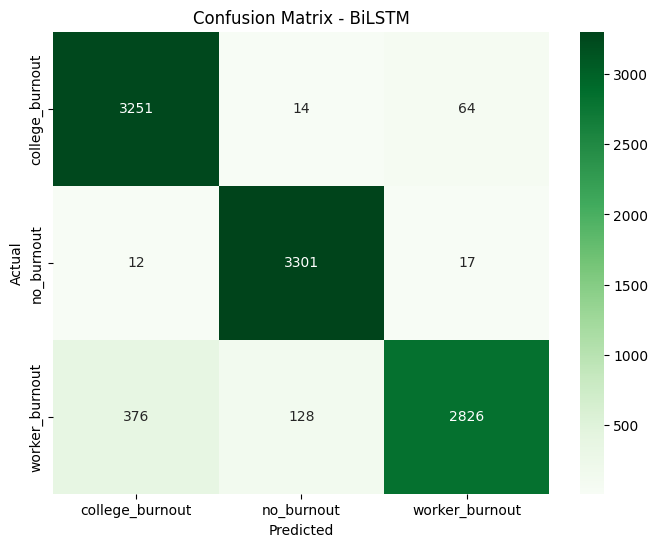

In [45]:
# ==========================================
# 15. Metode 5: Deep Learning (Bidirectional LSTM)
# ==========================================
print("\n\n==============================================")
print("🤖 MEMULAI TRAINING MODEL BIDIRECTIONAL LSTM")
print("==============================================")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# -------------------------------------------------
# 15.1 Tokenization untuk LSTM
# -------------------------------------------------
print("🔤 Melakukan tokenisasi teks...")
vocab_size = 50000  # cukup besar untuk dataset burnout
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_resampled)  # gunakan data hasil oversampling

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# -------------------------------------------------
# 15.2 Padding (agar semua panjangnya sama)
# -------------------------------------------------
max_len = 150  # panjang umum untuk tweet/short text
print(f"📏 Memakai max_len = {max_len}")

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("Bentuk X_train_pad:", X_train_pad.shape)
print("Bentuk X_test_pad :", X_test_pad.shape)

# -------------------------------------------------
# 15.3 Membangun model BiLSTM
# -------------------------------------------------
num_classes = len(le.classes_)
print("Jumlah kelas:", num_classes)

model_lstm = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),

    Bidirectional(LSTM(64, return_sequences=False)),

    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model_lstm.summary())

# -------------------------------------------------
# 15.4 Training
# -------------------------------------------------
print("\n🚀 Training Bidirectional LSTM...")
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=8,
    batch_size=64,
    verbose=1
)

# -------------------------------------------------
# 15.5 Evaluate
# -------------------------------------------------
print("\n📊 Evaluasi Model BiLSTM...")
loss, acc = model_lstm.evaluate(X_test_pad, y_test, verbose=0)
print(f"🎉 Akurasi Test BiLSTM: {acc*100:.2f}%")

# Prediksi & Classification Report
y_pred_lstm = model_lstm.predict(X_test_pad)
y_pred_lstm = y_pred_lstm.argmax(axis=1)

print("\nLaporan Klasifikasi BiLSTM:")
print(classification_report(
    y_test,
    y_pred_lstm,
    target_names=le.classes_,
    zero_division=0
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - BiLSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Fine-Tuning Pre-Trained Model (DistilBERT)**

🤗 MEMULAI TRAINING PRE-TRAINED MODEL (DISTILBERT)
Device yang digunakan: cuda
📥 Mengunduh Tokenizer: distilbert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

⚙️ Encoding data train dan test...
📥 Mengunduh Model: distilbert-base-uncased...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Mulai Fine-Tuning DistilBERT (Proses ini memakan waktu)...



📊 Melakukan Evaluasi Akhir...


🎉 Akurasi DistilBERT: 96.63%
Membuat prediksi pada data test...

Laporan Klasifikasi DistilBERT:
                 precision    recall  f1-score   support

college_burnout       0.94      0.98      0.96      3329
     no_burnout       0.98      1.00      0.99      3330
 worker_burnout       0.98      0.92      0.95      3330

       accuracy                           0.97      9989
      macro avg       0.97      0.97      0.97      9989
   weighted avg       0.97      0.97      0.97      9989



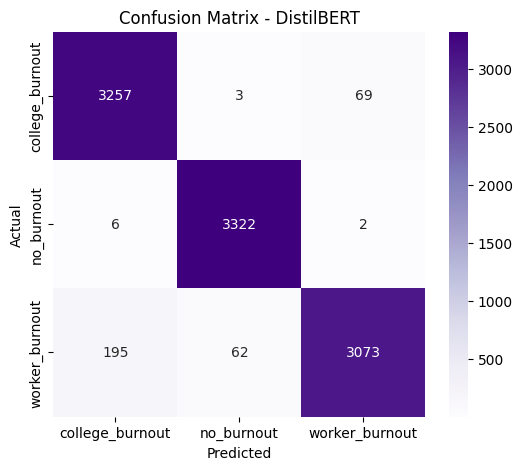


✅ Proses Fine-Tuning Selesai.


In [47]:
# ==========================================
# CELL 3: FINE-TUNING PRE-TRAINED MODEL (DISTILBERT)
# ==========================================
# Pastikan Cell 1 sudah dijalankan sebelum menjalankan cell ini.

print("🤗 MEMULAI TRAINING PRE-TRAINED MODEL (DISTILBERT)")

# 1. Instalasi Library (Jika belum ada di Colab)
# Biasanya transformers sudah ada, tapi untuk memastikan:
try:
    import transformers
except ImportError:
    !pip install transformers accelerate -q
    import transformers

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cek GPU (Sangat disarankan untuk BERT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device yang digunakan: {device}")

# ==========================================
# 1. TOKENISASI & DATASET
# ==========================================
model_name = 'distilbert-base-uncased'
print(f"📥 Mengunduh Tokenizer: {model_name}...")
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Encoding Data
# Kita konversi numpy array ke list string agar bisa diterima tokenizer
print("⚙️ Encoding data train dan test...")
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Membuat Class Dataset PyTorch
class BurnoutDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Inisialisasi Dataset
train_dataset = BurnoutDataset(train_encodings, y_train)
test_dataset = BurnoutDataset(test_encodings, y_test)

# ==========================================
# 2. KONFIGURASI MODEL & TRAINING
# ==========================================
print(f"📥 Mengunduh Model: {model_name}...")
num_labels = len(le.classes_) # Mengambil jumlah kelas dari LabelEncoder di Cell 1
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

# Argumen Training
training_args = TrainingArguments(
    output_dir='./results',          # Folder output
    num_train_epochs=3,              # Jumlah epoch (3 biasanya cukup untuk fine-tuning)
    per_device_train_batch_size=16,  # Batch size (kurangi jika OOM/Out of Memory)
    per_device_eval_batch_size=16,
    warmup_steps=500,                # Steps pemanasan learning rate
    weight_decay=0.01,               # Regularisasi
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",           # Evaluasi setiap akhir epoch
    save_strategy="epoch",           # Simpan model setiap akhir epoch
    load_best_model_at_end=True,     # Load model terbaik di akhir training
    metric_for_best_model="accuracy",
    report_to="none"                 # Jangan kirim log ke WandB/pihak ketiga
)

# Fungsi Metrik
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# ==========================================
# 3. EKSEKUSI TRAINING
# ==========================================
print("\n🚀 Mulai Fine-Tuning DistilBERT (Proses ini memakan waktu)...")
trainer.train()

# ==========================================
# 4. EVALUASI
# ==========================================
print("\n📊 Melakukan Evaluasi Akhir...")
eval_results = trainer.evaluate()
print(f"🎉 Akurasi DistilBERT: {eval_results['eval_accuracy']*100:.2f}%")

# Prediksi Detail
print("Membuat prediksi pada data test...")
preds_output = trainer.predict(test_dataset)
y_pred_bert = np.argmax(preds_output.predictions, axis=1)

# Laporan Klasifikasi
print("\nLaporan Klasifikasi DistilBERT:")
print(classification_report(y_test, y_pred_bert, target_names=le.classes_, zero_division=0))

# Confusion Matrix
cm_bert = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n✅ Proses Fine-Tuning Selesai.")

# **Low-Rank Adaptation (LoRA)**

🔥 MEMULAI TRAINING DENGAN METODE LoRA (Low-Rank Adaptation)
⚙️ Melakukan tokenisasi untuk LoRA...
📥 Memuat Base Model: distilbert-base-uncased...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Statistik Parameter LoRA (Lihat betapa sedikit yang dilatih):
trainable params: 1,035,267 || all params: 67,991,046 || trainable%: 1.5227

🚀 Mulai Training LoRA...



📊 Evaluasi Model LoRA...


🎉 Akurasi Model LoRA: 95.58%

Laporan Klasifikasi LoRA:
                 precision    recall  f1-score   support

college_burnout       0.93      0.97      0.95      3329
     no_burnout       0.97      1.00      0.99      3330
 worker_burnout       0.97      0.90      0.93      3330

       accuracy                           0.96      9989
      macro avg       0.96      0.96      0.96      9989
   weighted avg       0.96      0.96      0.96      9989



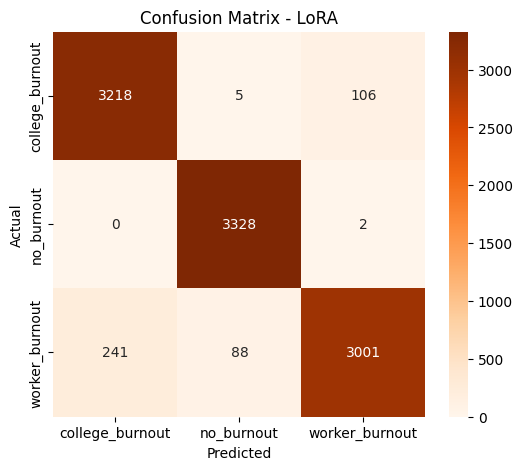


✅ Proses LoRA Selesai.


In [52]:
# ==========================================
# CELL 4: EFFICIENT FINE-TUNING DENGAN LoRA (PEFT)
# ==========================================
# Pastikan Cell 1 sudah dijalankan sebelum ini.

print("🔥 MEMULAI TRAINING DENGAN METODE LoRA (Low-Rank Adaptation)")

# 1. Instalasi Library PEFT (Jika belum ada)
try:
    import peft
except ImportError:
    print("📥 Menginstal library PEFT & Evaluate...")
    !pip install -q peft evaluate

from peft import get_peft_model, LoraConfig, TaskType
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cek Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==========================================
# 2. PERSIAPAN DATA (TOKENISASI)
# ==========================================
# Kita load tokenizer baru untuk memastikan kompatibilitas
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)


# Fungsi Tokenisasi ulang (karena LoRA butuh format input spesifik)
def tokenize_function(texts):
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )

print("⚙️ Melakukan tokenisasi untuk LoRA...")
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Dataset Class (Sederhana)
class BurnoutLoRADataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Buat Dataset
train_dataset = BurnoutLoRADataset(train_encodings, y_train)
test_dataset = BurnoutLoRADataset(test_encodings, y_test)

# ==========================================
# 3. KONFIGURASI LoRA & MODEL
# ==========================================
# Load Base Model
print(f"📥 Memuat Base Model: {model_name}...")
num_labels = len(le.classes_)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Konfigurasi LoRA
#
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, # Sequence Classification
    r=16,                       # Rank (semakin besar semakin kompleks, tapi lebih berat)
    lora_alpha=32,              # Scaling factor
    lora_dropout=0.1,           # Dropout untuk regularisasi
    bias="none",
    target_modules=["q_lin", "k_lin", "v_lin"] # Targetkan layer attention
)

# Bungkus model dengan LoRA
model = get_peft_model(model, peft_config)
model.to(device)

print("\n📊 Statistik Parameter LoRA (Lihat betapa sedikit yang dilatih):")
model.print_trainable_parameters()

# ==========================================
# 4. TRAINING EXECUTION
# ==========================================
training_args = TrainingArguments(
    output_dir='./results_lora',
    num_train_epochs=5,              # LoRA butuh epoch sedikit lebih banyak dari full fine-tuning
    per_device_train_batch_size=32,  # Bisa batch size lebih besar karena hemat memori
    per_device_eval_batch_size=32,
    learning_rate=1e-3,              # Learning rate LoRA biasanya lebih tinggi (1e-3 vs 2e-5)
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("\n🚀 Mulai Training LoRA...")
trainer.train()

# ==========================================
# 5. EVALUASI
# ==========================================
print("\n📊 Evaluasi Model LoRA...")
preds_output = trainer.predict(test_dataset)
y_pred_lora = np.argmax(preds_output.predictions, axis=1)

# Akurasi
acc_lora = accuracy_score(y_test, y_pred_lora)
print(f"🎉 Akurasi Model LoRA: {acc_lora*100:.2f}%")

# Classification Report
print("\nLaporan Klasifikasi LoRA:")
print(classification_report(y_test, y_pred_lora, target_names=le.classes_, zero_division=0))

# Confusion Matrix
cm_lora = confusion_matrix(y_test, y_pred_lora)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lora, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - LoRA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n✅ Proses LoRA Selesai.")

# **Explainable AI (XAI)**

In [50]:
# ==========================================
# CELL 8 (REVISI): DEBUGGING XAI LIME
# ==========================================
import torch.nn.functional as F

# Install LIME if not already installed
try:
    import lime
except ImportError:
    !pip install lime -q
    import lime

from lime.lime_text import LimeTextExplainer
import sys

print("🔍 1. Inisialisasi LIME...")

# --- Fungsi Prediktor ---
def predictor_fn(texts):
    model.eval()
    # Pindahkan input ke device yang sama dengan model
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)

    return probs.cpu().numpy()

# --- Inisialisasi ---
explainer = LimeTextExplainer(class_names=le.classes_)

# Pilih data
idx_sample = 10 # Coba ganti indeks ini jika error
text_to_explain = str(X_test[idx_sample]) # Pastikan string
true_label_idx = y_test[idx_sample] # Corrected from .iloc[idx_sample]
try:
    true_label_name = le.classes_[true_label_idx]
except:
    true_label_name = str(true_label_idx)

print(f"📝 Menganalisis teks: '{text_to_explain[:50]}...' وصلت")
print(f"⏳ Sedang menghitung (Mohon tunggu 30-60 detik)...")

# --- Generate Penjelasan ---
try:
    exp = explainer.explain_instance(
        text_to_explain,
        predictor_fn,
        num_features=10,
        top_labels=1
    )
    print("✅ Perhitungan Selesai!")
except Exception as e:
    print(f"❌ Error saat perhitungan LIME: {e}")
    sys.exit()

# --- OUTPUT 1: LIST TEKS (PASTI MUNCUL) ---
print("\n" + "="*30)
print("HASIL ANALISIS (TEXT MODE)")
print("="*30)
print("Probabilitas Prediksi:", exp.predict_proba)
print("\nBobot Kata (Nilai positif = mendukung prediksi):")
# Tampilkan list bobot kata secara manual
# FIX: Pass the predicted label index to as_list()
predicted_label_idx = np.argmax(exp.predict_proba) # Get the index of the highest probability class
weights = exp.as_list(label=predicted_label_idx)
for word, weight in weights:
    status = "MENDUKUNG" if weight > 0 else "MENENTANG"
    print(f"{word:15} : {weight:.4f} [{status}]")

# --- OUTPUT 2: VISUALISASI NOTEBOOK ---
print("\n" + "="*30)
print("HASIL VISUALISASI")
print("="*30)
try:
    # Memaksa render HTML di Colab
    from IPython.display import HTML
    html_data = exp.as_html()
    display(HTML(html_data))
except Exception as e:
    print("Gagal merender visualisasi di notebook.")

# --- OUTPUT 3: SIMPAN KE FILE (CADANGAN) ---
print("\n💾 Menyimpan hasil ke 'lime_result.html'...")
exp.save_to_file('lime_result.html')
print("✅ Cek tab 'Files' di sebelah kiri Colab, download 'lime_result.html' dan buka di browser.")

🔍 1. Inisialisasi LIME...
📝 Menganalisis teks: 'wa walking class feeling miserable thinking used a...' وصلت
⏳ Sedang menghitung (Mohon tunggu 30-60 detik)...
✅ Perhitungan Selesai!

HASIL ANALISIS (TEXT MODE)
Probabilitas Prediksi: [9.9912006e-01 4.3304203e-04 4.4693102e-04]

Bobot Kata (Nilai positif = mendukung prediksi):
sociology       : 0.3543 [MENDUKUNG]
class           : 0.3391 [MENDUKUNG]
thinking        : 0.0289 [MENDUKUNG]
used            : 0.0183 [MENDUKUNG]
wa              : 0.0177 [MENDUKUNG]
miserable       : 0.0107 [MENDUKUNG]
walking         : 0.0018 [MENDUKUNG]
feeling         : -0.0005 [MENENTANG]
adore           : -0.0001 [MENENTANG]

HASIL VISUALISASI



💾 Menyimpan hasil ke 'lime_result.html'...
✅ Cek tab 'Files' di sebelah kiri Colab, download 'lime_result.html' dan buka di browser.
